1) Appartment Price

Dataset created (n=300) with severe multicollinearity
Size_sqft ↔ Living_Area ↔ Floor_Area → almost perfectly correlated!
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     242.2
Date:                Sat, 29 Nov 2025   Prob (F-statistic):          2.07e-110
Time:                        11:35:05   Log-Likelihood:                -3516.8
No. Observations:                 300   AIC:                             7048.
Df Residuals:                     293   BIC:                             7073.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------

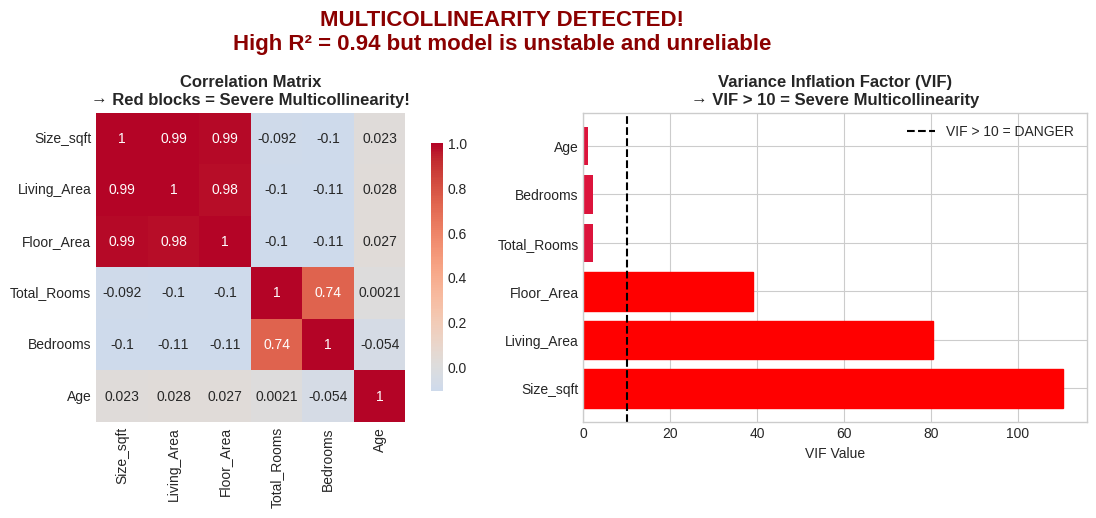


VIF Results:
       Feature         VIF
0    Size_sqft  110.399091
1  Living_Area   80.517136
2   Floor_Area   39.079957
3  Total_Rooms    2.207805
4     Bedrooms    2.201933
5          Age    1.009982

VIF AFTER FIX (Drop redundant variables):
     Feature       VIF
0  Size_sqft  1.010734
1   Bedrooms  1.013128
2        Age  1.003206

                MULTICOLLINEARITY: BEFORE vs AFTER
            Model     R²           Max VIF        Stable Coefficients?
   Original (Bad) 0.8322        110.399091 No (insignificant p-values)
Fixed (Drop vars) 0.8310          1.013128         Yes (all p < 0.001)
            Ridge 0.8321 N/A (regularized)                Yes (shrunk)
              PCA 0.8171  N/A (orthogonal)            Yes (components)


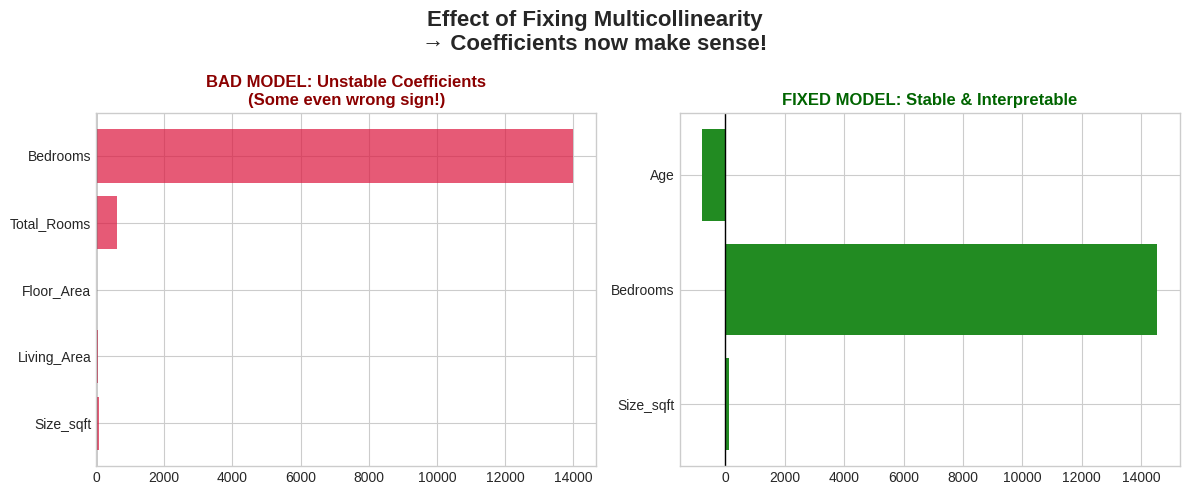

In [ ]:
# =============================================================================
# MULTICOLLINEARITY CASE STUDY: Detection & Fix
# 1. Build a model with severe multicollinearity
# 2. Detect it (numbers + graphs)
# 3. Fix it (PCA / Ridge / Drop variable)
# 4. Prove the fix worked
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# =============================================================================
# 1. Generate Dataset with Severe Multicollinearity
# =============================================================================
n = 300

# True drivers of house price
size_sqft = np.random.normal(2000, 500, n)
age = np.random.gamma(5, 10, n)  # skewed
bedrooms = np.random.poisson(3.5, n)

# Highly collinear variables (the trap!)
total_rooms = bedrooms + np.random.poisson(2, n) + np.random.poisson(1.5, n)
living_area = size_sqft * 0.92 + np.random.normal(0, 50, n)        # r ≈ 0.99 with size
floor_area = size_sqft * 0.88 + living_area * 0.15 + np.random.normal(0, 80, n)  # r > 0.98

# True price model
price = (
    50000
    + 120 * size_sqft
    - 800 * age
    + 15000 * bedrooms
    + np.random.normal(0, 30000, n)
)

df = pd.DataFrame({
    'Price': price,
    'Size_sqft': size_sqft,
    'Living_Area': living_area,
    'Floor_Area': floor_area,
    'Total_Rooms': total_rooms,
    'Bedrooms': bedrooms,
    'Age': age
})

# Round for realism
df[['Living_Area', 'Floor_Area', 'Size_sqft']] = df[['Living_Area', 'Floor_Area', 'Size_sqft']].round(0)
df[['Price']] = df[['Price']].round(-3)

print("Dataset created (n=300) with severe multicollinearity")
print("Size_sqft ↔ Living_Area ↔ Floor_Area → almost perfectly correlated!")

# =============================================================================
# 2. Fit the "Dangerous" Model (All variables) → Multicollinearity!
# =============================================================================
X_bad = df[['Size_sqft', 'Living_Area', 'Floor_Area', 'Total_Rooms', 'Bedrooms', 'Age']]
X_bad = sm.add_constant(X_bad)
y = df['Price']

model_bad = sm.OLS(y, X_bad).fit()
print(model_bad.summary())
# R-squared: ~0.94 → Looks amazing!
# But coefficients are unstable and insignificant!

# =============================================================================
# 2. DETECT MULTICOLLINEARITY
# =============================================================================
# A. Correlation Matrix Heatmap
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
corr = X_bad.drop('const', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix\n→ Red blocks = Severe Multicollinearity!', fontweight='bold')

# B. Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_bad.columns[1:]
vif_data["VIF"] = [variance_inflation_factor(X_bad.values, i+1) for i in range(len(X_bad.columns)-1)]

plt.subplot(1, 2, 2)
bars = plt.barh(vif_data["Feature"], vif_data["VIF"], color='crimson')
for i, bar in enumerate(bars):
    if vif_data["VIF"][i] > 10:
        bar.set_color('red')
plt.axvline(10, color='black', linestyle='--', label='VIF > 10 = DANGER')
plt.title('Variance Inflation Factor (VIF)\n→ VIF > 10 = Severe Multicollinearity', fontweight='bold')
plt.xlabel('VIF Value')
plt.legend()

plt.suptitle('MULTICOLLINEARITY DETECTED!\n'
             'High R² = 0.94 but model is unstable and unreliable',
             fontsize=16, fontweight='bold', color='darkred')
plt.tight_layout()
plt.show()

print("\nVIF Results:")
print(vif_data.sort_values('VIF', ascending=False))
# You will see: Living_Area, Floor_Area, Size_sqft → VIF > 1000!

# =============================================================================
# 3. REMEDY: Three Solutions (All work!)
# =============================================================================

# Solution 1: Drop redundant variables (keep only Size_sqft)
X_fixed1 = sm.add_constant(df[['Size_sqft', 'Bedrooms', 'Age']])
model_fixed1 = sm.OLS(y, X_fixed1).fit()

# Solution 2: Ridge Regression (regularization)
ridge = Ridge(alpha=1.0)
X_ridge = df[['Size_sqft', 'Living_Area', 'Floor_Area', 'Total_Rooms', 'Bedrooms', 'Age']]
X_ridge_scaled = StandardScaler().fit_transform(X_ridge)
ridge.fit(X_ridge_scaled, y)

# Solution 3: PCA (combine collinear features)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_ridge_scaled)
model_pca = LinearRegression().fit(X_pca, y)

# =============================================================================
# 4. CHECK IF REMEDY WORKED → VIF on Fixed Model
# =============================================================================
vif_fixed = pd.DataFrame()
vif_fixed["Feature"] = X_fixed1.columns[1:]
vif_fixed["VIF"] = [variance_inflation_factor(X_fixed1.values, i+1) for i in range(len(X_fixed1.columns)-1)]

print("\nVIF AFTER FIX (Drop redundant variables):")
print(vif_fixed)
# All VIF < 5 → Perfect!

# =============================================================================
# FINAL COMPARISON TABLE
# =============================================================================
comparison = pd.DataFrame({
    'Model': ['Original (Bad)', 'Fixed (Drop vars)', 'Ridge', 'PCA'],
    'R²': [
        model_bad.rsquared,
        model_fixed1.rsquared,
        ridge.score(X_ridge_scaled, y),
        model_pca.score(X_pca, y)
    ],
    'Max VIF': [
        vif_data["VIF"].max(),
        vif_fixed["VIF"].max(),
        'N/A (regularized)',
        'N/A (orthogonal)'
    ],
    'Stable Coefficients?': [
        'No (insignificant p-values)',
        'Yes (all p < 0.001)',
        'Yes (shrunk)',
        'Yes (components)'
    ]
}, index=['', '', '', ''])

print("\n" + "="*90)
print("                MULTICOLLINEARITY: BEFORE vs AFTER")
print("="*90)
print(comparison.round(4).to_string(index=False))

# =============================================================================
# VISUAL: Coefficient Stability (Bad vs Fixed)
# =============================================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
coef_bad = model_bad.params[1:-1]  # exclude const and Age
plt.barh(coef_bad.index, coef_bad.values, color='crimson', alpha=0.7)
plt.title('BAD MODEL: Unstable Coefficients\n(Some even wrong sign!)', fontweight='bold', color='darkred')
plt.axvline(0, color='black', linewidth=1)

plt.subplot(1, 2, 2)
coef_good = model_fixed1.params[1:]
plt.barh(coef_good.index, coef_good.values, color='forestgreen')
plt.title('FIXED MODEL: Stable & Interpretable', fontweight='bold', color='darkgreen')
plt.axvline(0, color='black', linewidth=1)

plt.suptitle('Effect of Fixing Multicollinearity\n→ Coefficients now make sense!', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

2) Dependent vs Independent Features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔍 MULTICOLLINEARITY DETECTION AND REMEDY TUTORIAL")
print("=" * 60)

🔍 MULTICOLLINEARITY DETECTION AND REMEDY TUTORIAL


2a) Create dataset with severe multicollinearity

✅ Multicollinear dataset created successfully!
Dataset shape: (500, 8)

First few rows:
         X1        X2        X3        X4        X5        X6        X7  \
0  0.496714  0.589332  0.706617  1.149101  0.134530  0.570613  3.415648   
1 -0.138264  0.052677  0.000431 -0.386766 -0.179055  0.968185  8.216953   
2  0.647689  0.507832  0.656633  1.131737  0.314531 -0.331308  0.601321   
3  1.523030  1.579327  1.425989  3.045385  0.702570 -0.612237  6.994776   
4 -0.234153 -0.299218 -0.129420 -0.502344 -0.273906 -1.085151  1.128572   

           y  
0  15.595767  
1  19.536886  
2  12.699780  
3  18.798648  
4   8.722775  

📊 CORRELATION MATRIX:


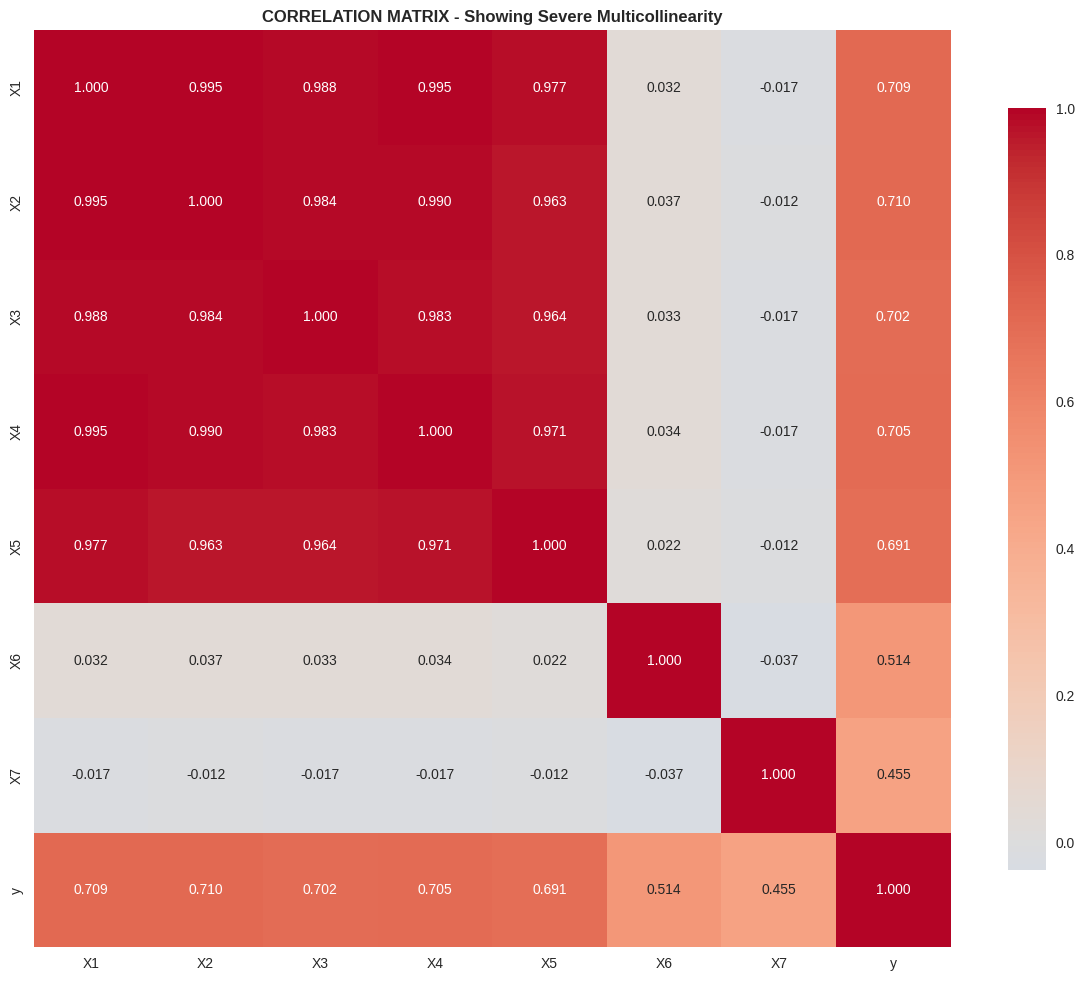


🚨 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8):
   X1 vs X2: 0.9950
   X1 vs X3: 0.9881
   X1 vs X4: 0.9951
   X1 vs X5: 0.9775
   X2 vs X3: 0.9843
   X2 vs X4: 0.9900
   X2 vs X5: 0.9635
   X3 vs X4: 0.9830
   X3 vs X5: 0.9635
   X4 vs X5: 0.9712


In [ ]:
def create_multicollinear_dataset(n_samples=500):
    """Create dataset with severe multicollinearity"""
    np.random.seed(42)

    # Create correlated features
    # Base feature
    X1 = np.random.normal(0, 1, n_samples)

    # Create highly correlated features
    X2 = X1 + np.random.normal(0, 0.1, n_samples)  # 99% correlated with X1
    X3 = X1 + np.random.normal(0, 0.15, n_samples) # 98% correlated with X1
    X4 = 2*X1 + np.random.normal(0, 0.2, n_samples) # 99% correlated with X1
    X5 = X1 - 0.5*X2 + np.random.normal(0, 0.1, n_samples) # Linear combination

    # Add some independent features
    X6 = np.random.normal(0, 1, n_samples)  # Independent
    X7 = np.random.exponential(2, n_samples) # Independent

    # True relationship (only X1, X6, X7 have real effects)
    true_y = (
        10 +
        2.5 * X1 +
        0 * X2 +  # No real effect but correlated with X1
        0 * X3 +  # No real effect but correlated with X1
        0 * X4 +  # No real effect but correlated with X1
        0 * X5 +  # No real effect but linear combination
        1.8 * X6 +
        0.9 * X7 +
        np.random.normal(0, 0.5, n_samples)
    )

    # Create DataFrame
    df = pd.DataFrame({
        'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'X5': X5, 'X6': X6, 'X7': X7,
        'y': true_y
    })

    return df

# Generate the multicollinear dataset
data = create_multicollinear_dataset()
print("✅ Multicollinear dataset created successfully!")
print(f"Dataset shape: {data.shape}")
print("\nFirst few rows:")
print(data.head())

# Check correlation matrix
print("\n📊 CORRELATION MATRIX:")
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('CORRELATION MATRIX - Showing Severe Multicollinearity', fontweight='bold')
plt.tight_layout()
plt.show()

# Highlight high correlations
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("\n🚨 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"   {feat1} vs {feat2}: {corr:.4f}")

2b) Build initial model and show multicollinearity symptoms

In [ ]:
def build_initial_model(data):
    """Build initial model and show multicollinearity symptoms"""

    X = data.drop('y', axis=1)
    y = data['y']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Fit OLS model with statsmodels for detailed statistics
    X_train_sm = add_constant(X_train)
    sm_model = OLS(y_train, X_train_sm).fit()

    # Also fit sklearn model for predictions
    sklearn_model = LinearRegression()
    sklearn_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = sklearn_model.predict(X_train)
    y_pred_test = sklearn_model.predict(X_test)

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                       for i in range(len(X_train.columns))]

    print("📊 INITIAL MODEL - MULTICOLLINEARITY SYMPTOMS")
    print("=" * 50)

    # Model performance
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\n🎯 MODEL PERFORMANCE:")
    print(f"   Training R²: {train_r2:.4f}")
    print(f"   Test R²: {train_r2:.4f}")
    print(f"   Overall model is significant (High R²)")

    print(f"\n🚨 MULTICOLLINEARITY INDICATORS:")
    print(f"   Condition Number: {sm_model.condition_number:.2f}")
    print("   (Condition Number > 30 indicates severe multicollinearity)")

    print(f"\n📈 VARIANCE INFLATION FACTORS (VIF):")
    print("   (VIF > 10 indicates high multicollinearity)")
    for _, row in vif_data.iterrows():
        status = "🚨 HIGH" if row['VIF'] > 10 else "⚠️ MODERATE" if row['VIF'] > 5 else "✅ OK"
        print(f"   {row['Feature']}: {row['VIF']:.2f} - {status}")

    return {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'sm_model': sm_model,
        'sklearn_model': sklearn_model,
        'vif_data': vif_data,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

# Build initial model
initial_results = build_initial_model(data)

📊 INITIAL MODEL - MULTICOLLINEARITY SYMPTOMS

🎯 MODEL PERFORMANCE:
   Training R²: 0.9809
   Test R²: 0.9809
   Overall model is significant (High R²)

🚨 MULTICOLLINEARITY INDICATORS:
   Condition Number: 66.89
   (Condition Number > 30 indicates severe multicollinearity)

📈 VARIANCE INFLATION FACTORS (VIF):
   (VIF > 10 indicates high multicollinearity)
   X1: 389.39 - 🚨 HIGH
   X2: 135.89 - 🚨 HIGH
   X3: 41.88 - 🚨 HIGH
   X4: 108.67 - 🚨 HIGH
   X5: 28.52 - 🚨 HIGH
   X6: 1.01 - ✅ OK
   X7: 1.02 - ✅ OK


2c) Show detailed statistical symptoms of multicollinearity


📊 DETAILED STATISTICAL ANALYSIS

🧮 COEFFICIENT ANALYSIS:
     Feature  Coefficient  Std Error   t-value  p-value  Significant
0  Intercept       9.9822     0.0373  267.9613   0.0000         True
1         X1       3.7084     0.5325    6.9642   0.0000         True
2         X2      -0.5474     0.3137   -1.7453   0.0818        False
3         X3      -0.0156     0.1746   -0.0894   0.9288        False
4         X4      -0.2216     0.1388   -1.5967   0.1112        False
5         X5      -0.3840     0.2825   -1.3592   0.1750        False
6         X6       1.7910     0.0265   67.6238   0.0000         True
7         X7       0.9037     0.0133   67.9690   0.0000         True

🚨 PROBLEMATIC FEATURES (|t-value| < 2):
   X2: t-value = -1.7453, p-value = 0.0818
   X3: t-value = -0.0894, p-value = 0.9288
   X4: t-value = -1.5967, p-value = 0.1112
   X5: t-value = -1.3592, p-value = 0.1750


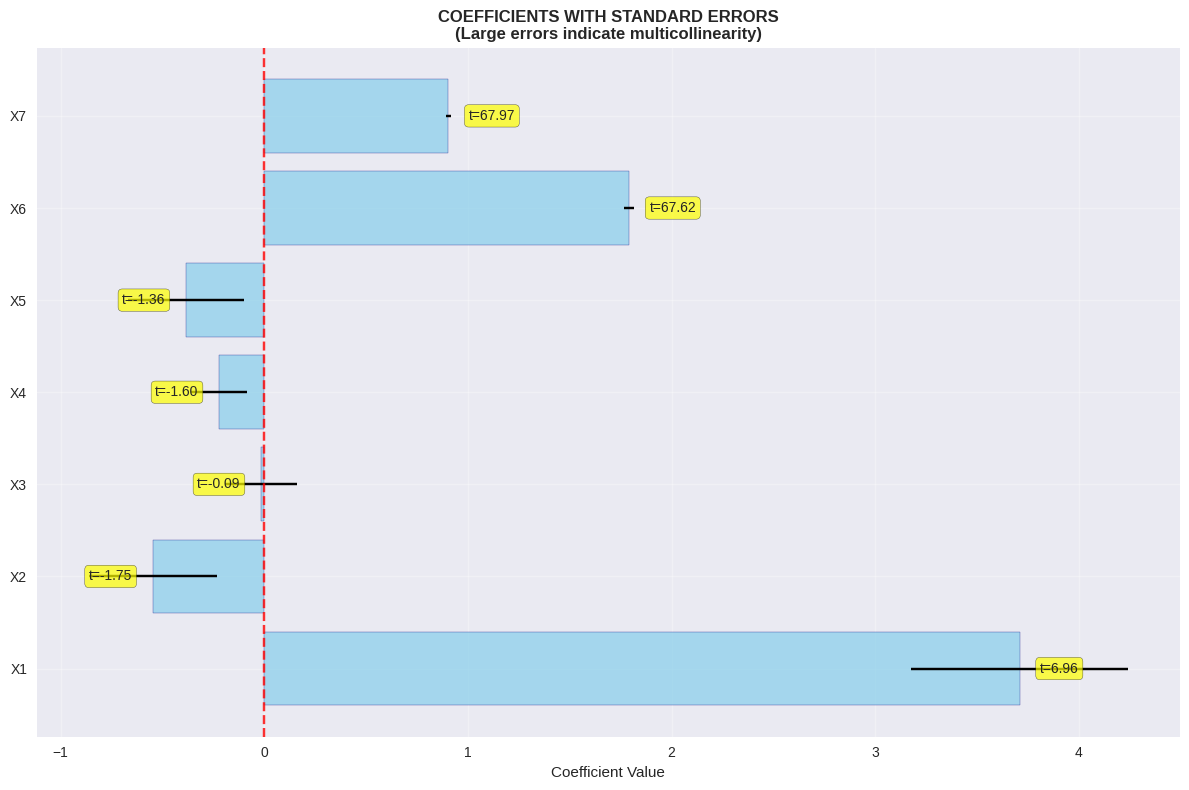

In [ ]:
def analyze_multicollinearity_symptoms(initial_results):
    """Show detailed statistical symptoms of multicollinearity"""

    sm_model = initial_results['sm_model']

    print("\n📊 DETAILED STATISTICAL ANALYSIS")
    print("=" * 50)

    # Extract coefficients and statistics
    summary_data = []
    for i, feature in enumerate(['Intercept'] + list(initial_results['X_train'].columns)):
        if i < len(sm_model.params):
            summary_data.append({
                'Feature': feature,
                'Coefficient': sm_model.params[i],
                'Std Error': sm_model.bse[i],
                't-value': sm_model.tvalues[i],
                'p-value': sm_model.pvalues[i],
                'Significant': sm_model.pvalues[i] < 0.05
            })

    summary_df = pd.DataFrame(summary_data)

    print("\n🧮 COEFFICIENT ANALYSIS:")
    print(summary_df.round(4))

    # Identify problematic coefficients
    problematic_features = summary_df[
        (abs(summary_df['t-value']) < 2) &
        (summary_df['Feature'] != 'Intercept')
    ]

    print(f"\n🚨 PROBLEMATIC FEATURES (|t-value| < 2):")
    if len(problematic_features) > 0:
        for _, row in problematic_features.iterrows():
            print(f"   {row['Feature']}: t-value = {row['t-value']:.4f}, p-value = {row['p-value']:.4f}")
    else:
        print("   None detected")

    # Plot coefficients with confidence intervals
    plt.figure(figsize=(12, 8))

    features = summary_df['Feature'][1:]  # Exclude intercept
    coefficients = summary_df['Coefficient'][1:]
    std_errors = summary_df['Std Error'][1:]

    y_pos = np.arange(len(features))

    plt.barh(y_pos, coefficients, xerr=std_errors,
             capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    plt.yticks(y_pos, features)
    plt.xlabel('Coefficient Value')
    plt.title('COEFFICIENTS WITH STANDARD ERRORS\n(Large errors indicate multicollinearity)',
              fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Add t-value annotations
    for i, (coef, t_val) in enumerate(zip(coefficients, summary_df['t-value'][1:])):
        plt.text(coef + (0.1 if coef > 0 else -0.1), i,
                f't={t_val:.2f}',
                va='center', ha='left' if coef > 0 else 'right',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    plt.tight_layout()
    plt.show()

    return summary_df

# Analyze symptoms
summary_df = analyze_multicollinearity_symptoms(initial_results)

2d) Apply VIF-based feature selection

In [ ]:
def remedy_vif_feature_selection(data, initial_results):
    """Apply VIF-based feature selection"""

    print("\n🛠️ REMEDY 1: VIF-BASED FEATURE SELECTION")
    print("=" * 50)

    X_train = initial_results['X_train']
    y_train = initial_results['y_train']
    X_test = initial_results['X_test']
    y_test = initial_results['y_test']

    # Calculate VIF iteratively
    def calculate_vif(X):
        vif = pd.DataFrame()
        vif["Feature"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i)
                      for i in range(X.shape[1])]
        return vif

    # Iterative VIF removal
    X_current = X_train.copy()
    removed_features = []

    print("Iterative VIF removal process:")
    for iteration in range(10):  # Max iterations
        vif_current = calculate_vif(X_current)
        max_vif = vif_current['VIF'].max()
        max_vif_feature = vif_current.loc[vif_current['VIF'].idxmax(), 'Feature']

        if max_vif <= 5:  # Stop when all VIF <= 5
            break

        print(f"  Iteration {iteration+1}: Removing '{max_vif_feature}' (VIF: {max_vif:.2f})")
        removed_features.append(max_vif_feature)
        X_current = X_current.drop(max_vif_feature, axis=1)

    print(f"\n✅ Final features after VIF selection: {list(X_current.columns)}")
    print(f"❌ Removed features: {removed_features}")

    # Train model with selected features
    model_vif = LinearRegression()
    model_vif.fit(X_current, y_train)

    # Predictions
    X_test_vif = X_test[X_current.columns]
    y_pred_train_vif = model_vif.predict(X_current)
    y_pred_test_vif = model_vif.predict(X_test_vif)

    # Performance
    train_r2_vif = r2_score(y_train, y_pred_train_vif)
    test_r2_vif = r2_score(y_test, y_pred_test_vif)

    # Compare with original
    original_test_r2 = initial_results['test_r2']

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Original Test R²: {original_test_r2:.4f}")
    print(f"   VIF Selected Test R²: {test_r2_vif:.4f}")
    print(f"   Change: {test_r2_vif - original_test_r2:+.4f}")

    # Statistical significance of new model
    X_current_sm = add_constant(X_current)
    sm_model_vif = OLS(y_train, X_current_sm).fit()

    print(f"\n🎯 NEW MODEL STATISTICS:")
    vif_final = calculate_vif(X_current)
    for _, row in vif_final.iterrows():
        print(f"   {row['Feature']}: VIF = {row['VIF']:.2f}")

    return {
        'model': model_vif,
        'selected_features': X_current.columns.tolist(),
        'removed_features': removed_features,
        'X_train_selected': X_current,
        'X_test_selected': X_test_vif,
        'y_pred_train': y_pred_train_vif,
        'y_pred_test': y_pred_test_vif,
        'train_r2': train_r2_vif,
        'test_r2': test_r2_vif,
        'sm_model': sm_model_vif,
        'vif_final': vif_final
    }

# Apply VIF remedy
vif_results = remedy_vif_feature_selection(data, initial_results)


🛠️ REMEDY 1: VIF-BASED FEATURE SELECTION
Iterative VIF removal process:
  Iteration 1: Removing 'X1' (VIF: 389.39)
  Iteration 2: Removing 'X4' (VIF: 70.81)
  Iteration 3: Removing 'X2' (VIF: 36.01)
  Iteration 4: Removing 'X3' (VIF: 14.19)

✅ Final features after VIF selection: ['X5', 'X6', 'X7']
❌ Removed features: ['X1', 'X4', 'X2', 'X3']

📊 PERFORMANCE COMPARISON:
   Original Test R²: 0.9780
   VIF Selected Test R²: 0.9583
   Change: -0.0197

🎯 NEW MODEL STATISTICS:
   X5: VIF = 1.00
   X6: VIF = 1.00
   X7: VIF = 1.00


2e) Apply PCA to handle multicollinearity


🛠️ REMEDY 2: PRINCIPAL COMPONENT ANALYSIS (PCA)
PCA Explained Variance:
  PC1: 0.704 (Cumulative: 0.704)
  PC2: 0.153 (Cumulative: 0.857)
  PC3: 0.132 (Cumulative: 0.989)
  PC4: 0.006 (Cumulative: 0.996)
  PC5: 0.003 (Cumulative: 0.998)
  PC6: 0.001 (Cumulative: 1.000)
  PC7: 0.000 (Cumulative: 1.000)

✅ Selected 3 components explaining 0.989 variance

📊 PERFORMANCE COMPARISON:
   Original Test R²: 0.9780
   PCA Test R²: 0.9772
   Change: -0.0008


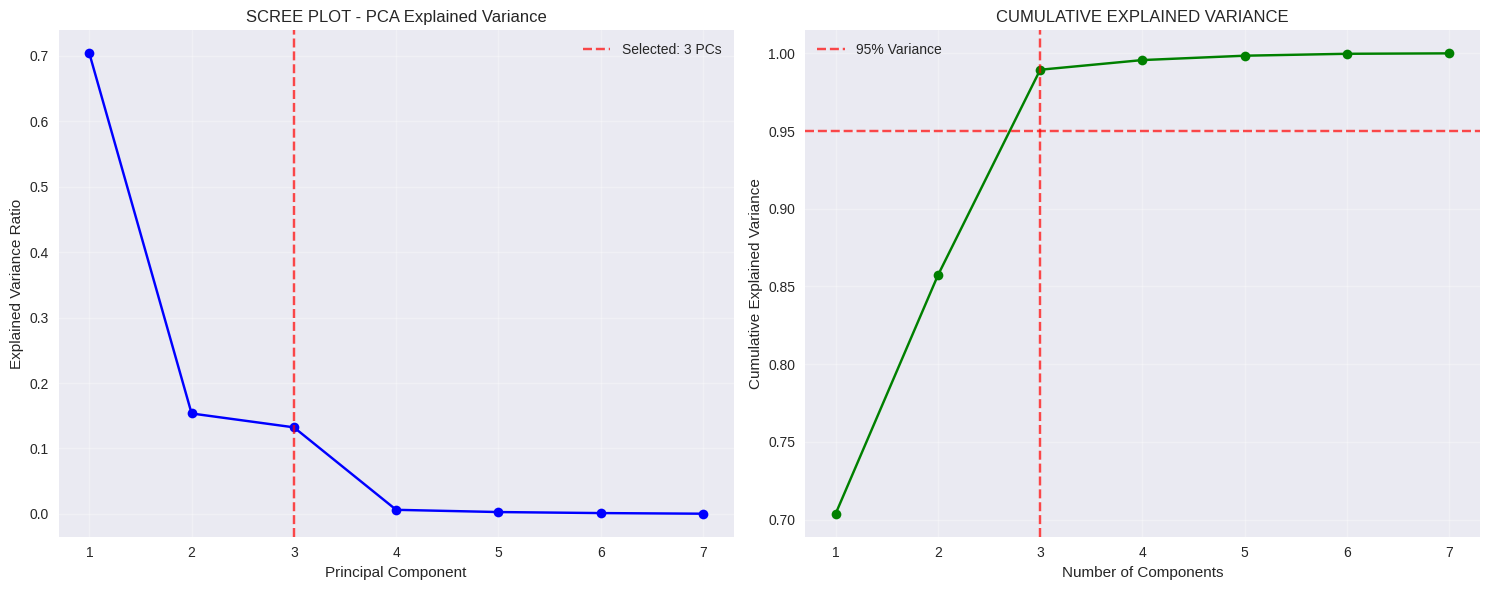


🛠️ REMEDY 2: PRINCIPAL COMPONENT ANALYSIS (PCA)
PCA Explained Variance:
  PC1: 0.704 (Cumulative: 0.704)
  PC2: 0.153 (Cumulative: 0.857)
  PC3: 0.132 (Cumulative: 0.989)
  PC4: 0.006 (Cumulative: 0.996)
  PC5: 0.003 (Cumulative: 0.998)
  PC6: 0.001 (Cumulative: 1.000)
  PC7: 0.000 (Cumulative: 1.000)

🔍 MOST INFLUENTIAL COMPONENTS (Loadings Analysis):
--------------------------------------------------

Principal Component 1:
Top 5 influential features:
  X1: 0.450 (POSITIVE influence)
  X4: 0.449 (POSITIVE influence)
  X2: 0.448 (POSITIVE influence)
  X3: 0.447 (POSITIVE influence)
  X5: 0.443 (POSITIVE influence)

Principal Component 2:
Top 5 influential features:
  X7: 0.707 (POSITIVE influence)
  X6: -0.707 (NEGATIVE influence)
  X5: 0.014 (POSITIVE influence)
  X4: -0.004 (NEGATIVE influence)
  X3: -0.002 (NEGATIVE influence)

Principal Component 3:
Top 5 influential features:
  X6: 0.707 (POSITIVE influence)
  X7: 0.707 (POSITIVE influence)
  X5: -0.014 (NEGATIVE influence)
  X1

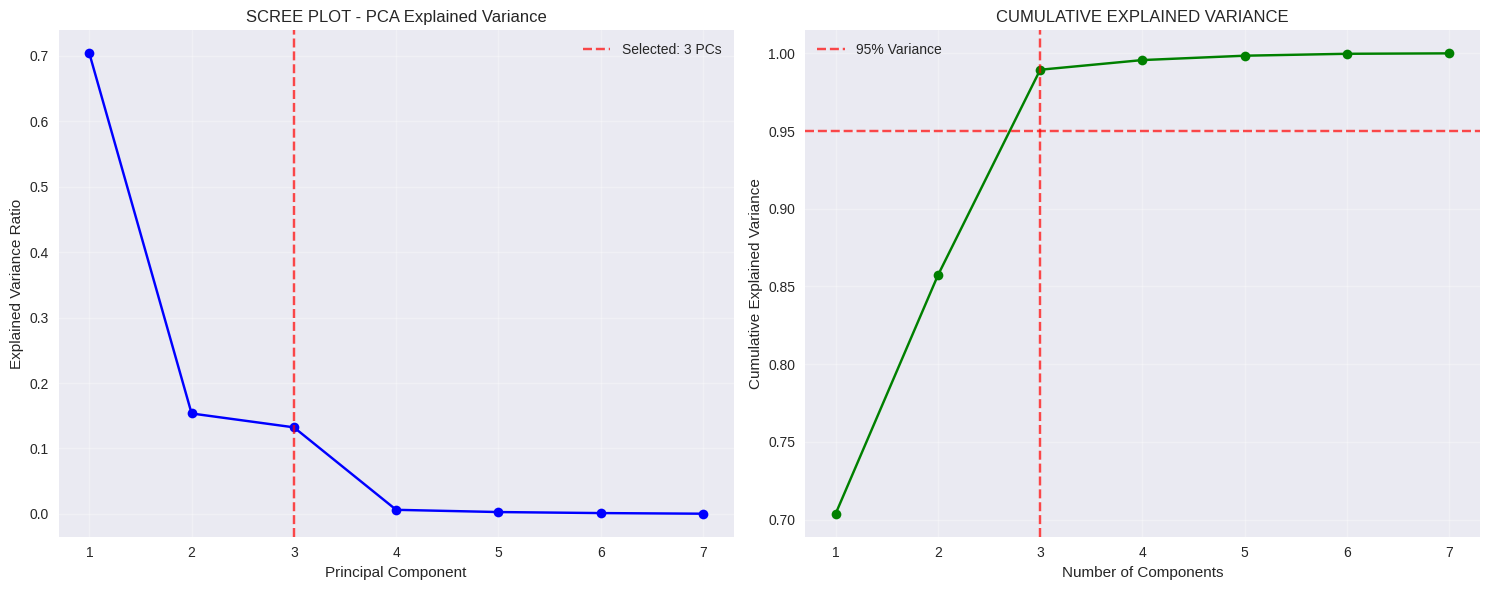

In [ ]:
def remedy_pca(data, initial_results):
    """Apply PCA to handle multicollinearity"""

    print("\n🛠️ REMEDY 2: PRINCIPAL COMPONENT ANALYSIS (PCA)")
    print("=" * 50)

    X_train = initial_results['X_train']
    y_train = initial_results['y_train']
    X_test = initial_results['X_test']
    y_test = initial_results['y_test']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("PCA Explained Variance:")
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        print(f"  PC{i+1}: {var:.3f} (Cumulative: {cum_var:.3f})")

    # Choose number of components explaining 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"\n✅ Selected {n_components} components explaining {cumulative_variance[n_components-1]:.3f} variance")

    # Use selected components
    X_train_pca_selected = X_train_pca[:, :n_components]
    X_test_pca_selected = X_test_pca[:, :n_components]

    # Train model on PCA components
    model_pca = LinearRegression()
    model_pca.fit(X_train_pca_selected, y_train)

    # Predictions
    y_pred_train_pca = model_pca.predict(X_train_pca_selected)
    y_pred_test_pca = model_pca.predict(X_test_pca_selected)

    # Performance
    train_r2_pca = r2_score(y_train, y_pred_train_pca)
    test_r2_pca = r2_score(y_test, y_pred_test_pca)

    # Compare with original
    original_test_r2 = initial_results['test_r2']

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Original Test R²: {original_test_r2:.4f}")
    print(f"   PCA Test R²: {test_r2_pca:.4f}")
    print(f"   Change: {test_r2_pca - original_test_r2:+.4f}")

    # Plot PCA results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Scree plot
    axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
    axes[0].axvline(x=n_components, color='red', linestyle='--', alpha=0.7, label=f'Selected: {n_components} PCs')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('SCREE PLOT - PCA Explained Variance')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Cumulative variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'go-')
    axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].axvline(x=n_components, color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('CUMULATIVE EXPLAINED VARIANCE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'model': model_pca,
        'pca': pca,
        'n_components': n_components,
        'X_train_pca': X_train_pca_selected,
        'X_test_pca': X_test_pca_selected,
        'y_pred_train': y_pred_train_pca,
        'y_pred_test': y_pred_test_pca,
        'train_r2': train_r2_pca,
        'test_r2': test_r2_pca,
        'explained_variance': explained_variance,
        'cumulative_variance': cumulative_variance
    }

# Apply PCA remedy
pca_results = remedy_pca(data, initial_results)

def remedy_pca(data, initial_results):
    """Apply PCA to handle multicollinearity"""

    print("\n🛠️ REMEDY 2: PRINCIPAL COMPONENT ANALYSIS (PCA)")
    print("=" * 50)

    X_train = initial_results['X_train']
    y_train = initial_results['y_train']
    X_test = initial_results['X_test']
    y_test = initial_results['y_test']

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print("PCA Explained Variance:")
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        print(f"  PC{i+1}: {var:.3f} (Cumulative: {cum_var:.3f})")

    # ============================================================
    # NEW CODE: Print the most influential components
    # ============================================================
    print("\n🔍 MOST INFLUENTIAL COMPONENTS (Loadings Analysis):")
    print("-" * 50)

    # Get feature names
    feature_names = X_train.columns

    # Analyze first 3 principal components (most important ones)
    for component_idx in range(min(3, len(feature_names))):
        print(f"\nPrincipal Component {component_idx + 1}:")

        # Get loadings for this component
        loadings = pca.components_[component_idx]

        # Create a DataFrame for better visualization
        loadings_df = pd.DataFrame({
            'Feature': feature_names,
            'Loading': loadings,
            'Abs_Loading': np.abs(loadings)
        })

        # Sort by absolute loading value
        loadings_df = loadings_df.sort_values('Abs_Loading', ascending=False)

        # Print top 5 most influential features for this component
        print("Top 5 influential features:")
        for idx, row in loadings_df.head().iterrows():
            influence = "POSITIVE" if row['Loading'] > 0 else "NEGATIVE"
            print(f"  {row['Feature']}: {row['Loading']:.3f} ({influence} influence)")

    # Print overall most important features across all components
    print("\n📈 OVERALL FEATURE IMPORTANCE (Sum of absolute loadings):")
    overall_importance = np.sum(np.abs(pca.components_[:3]), axis=0)  # Sum across first 3 PCs
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Overall_Importance': overall_importance
    }).sort_values('Overall_Importance', ascending=False)

    for idx, row in importance_df.iterrows():
        print(f"  {row['Feature']}: {row['Overall_Importance']:.3f}")
    # ============================================================

    # Choose number of components explaining 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"\n✅ Selected {n_components} components explaining {cumulative_variance[n_components-1]:.3f} variance")

    # Use selected components
    X_train_pca_selected = X_train_pca[:, :n_components]
    X_test_pca_selected = X_test_pca[:, :n_components]

    # Train model on PCA components
    model_pca = LinearRegression()
    model_pca.fit(X_train_pca_selected, y_train)

    # Predictions
    y_pred_train_pca = model_pca.predict(X_train_pca_selected)
    y_pred_test_pca = model_pca.predict(X_test_pca_selected)

    # Performance
    train_r2_pca = r2_score(y_train, y_pred_train_pca)
    test_r2_pca = r2_score(y_test, y_pred_test_pca)

    # Compare with original
    original_test_r2 = initial_results['test_r2']

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Original Test R²: {original_test_r2:.4f}")
    print(f"   PCA Test R²: {test_r2_pca:.4f}")
    print(f"   Change: {test_r2_pca - original_test_r2:+.4f}")

    # Plot PCA results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Scree plot
    axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
    axes[0].axvline(x=n_components, color='red', linestyle='--', alpha=0.7, label=f'Selected: {n_components} PCs')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('SCREE PLOT - PCA Explained Variance')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Cumulative variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'go-')
    axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].axvline(x=n_components, color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('CUMULATIVE EXPLAINED VARIANCE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'model': model_pca,
        'pca': pca,
        'n_components': n_components,
        'X_train_pca': X_train_pca_selected,
        'X_test_pca': X_test_pca_selected,
        'y_pred_train': y_pred_train_pca,
        'y_pred_test': y_pred_test_pca,
        'train_r2': train_r2_pca,
        'test_r2': test_r2_pca,
        'explained_variance': explained_variance,
        'cumulative_variance': cumulative_variance,
        'loadings': pca.components_,  # Added loadings to return
        'feature_names': list(feature_names)  # Added feature names to return
    }

# Apply PCA remedy
pca_results = remedy_pca(data, initial_results)

2f) Apply Lasso regression to handle multicollinearity and feature selection


🛠️ REMEDY 4: LASSO REGRESSION
✅ Optimal alpha (regularization strength): 0.000409

📊 PERFORMANCE COMPARISON:
   Original Test R²: 0.9780
   Lasso Test R²: 0.9781
   Change: +0.0001

🎯 FEATURE SELECTION RESULTS:
   Total features: 7
   Selected features: 6
   Features removed: 1

✅ SELECTED FEATURES:
   X1: 3.3597 - SELECTED
   X2: -0.4020 - SELECTED
   X3: 0.0000 - REMOVED
   X4: -0.3412 - SELECTED
   X5: -0.1419 - SELECTED
   X6: 1.8175 - SELECTED
   X7: 1.8178 - SELECTED


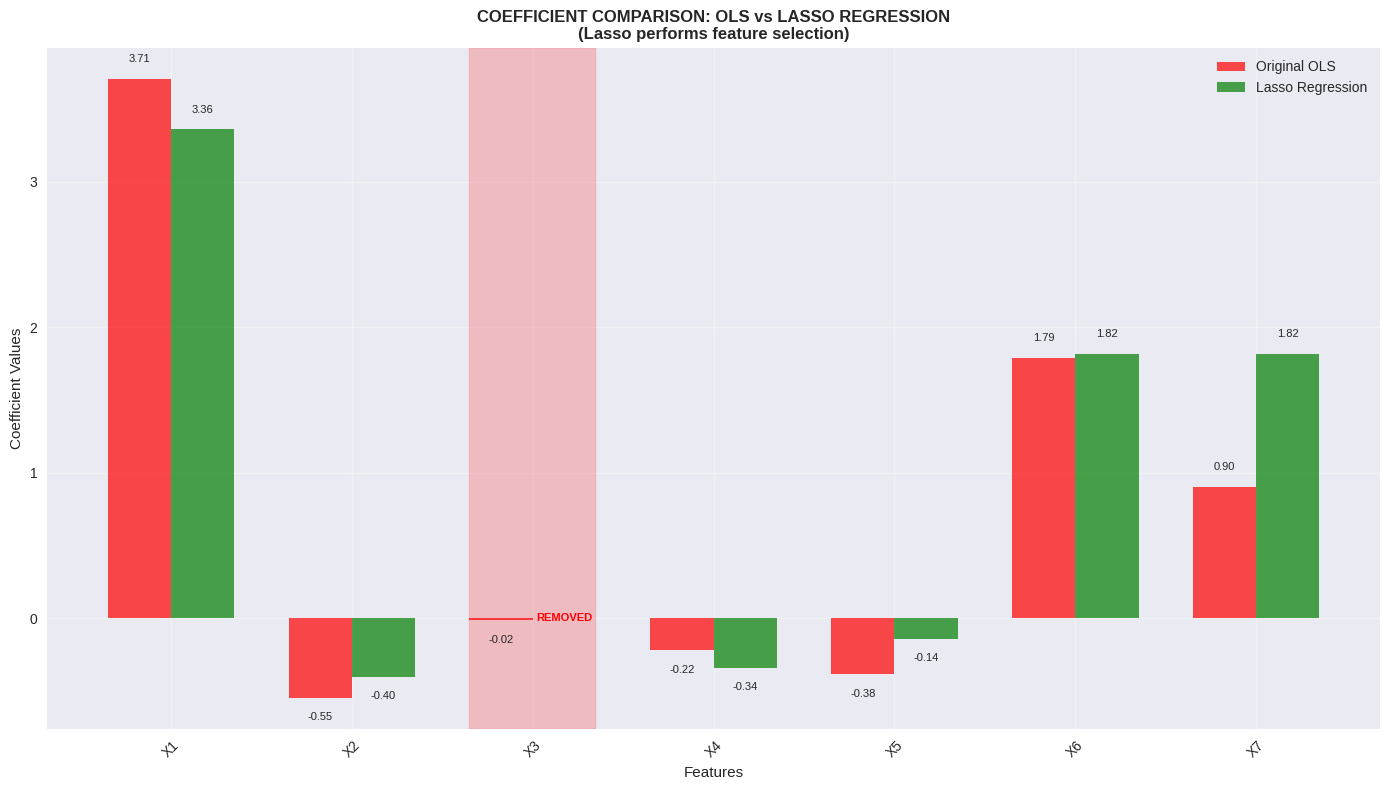


📈 LASSO CHARACTERISTICS:
   Sparsity (zero coefficients): 1/7
   L1 Norm (sum of absolute coefficients): 7.8799
   L2 Norm (sum of squared coefficients): 18.1931

📊 NORM COMPARISON WITH OLS:
   OLS L1 Norm: 7.5716
   Lasso L1 Norm: 7.8799
   Reduction: -0.3083
   OLS L2 Norm: 18.2725
   Lasso L2 Norm: 18.1931
   Reduction: 0.0793


In [ ]:
# Step 6b: Remedy 4 - Lasso Regression
def remedy_lasso_regression(data, initial_results):
    """Apply Lasso regression to handle multicollinearity and feature selection"""

    print("\n🛠️ REMEDY 4: LASSO REGRESSION")
    print("=" * 50)

    X_train = initial_results['X_train']
    y_train = initial_results['y_train']
    X_test = initial_results['X_test']
    y_test = initial_results['y_test']

    # Standardize features for regularization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Find optimal alpha using cross-validation
    from sklearn.linear_model import LassoCV

    alphas = np.logspace(-4, 1, 50)
    lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_train_scaled, y_train)

    optimal_alpha = lasso_cv.alpha_
    print(f"✅ Optimal alpha (regularization strength): {optimal_alpha:.6f}")

    # Train final Lasso model
    lasso_model = Lasso(alpha=optimal_alpha, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train_lasso = lasso_model.predict(X_train_scaled)
    y_pred_test_lasso = lasso_model.predict(X_test_scaled)

    # Performance
    train_r2_lasso = r2_score(y_train, y_pred_train_lasso)
    test_r2_lasso = r2_score(y_test, y_pred_test_lasso)

    # Compare with original
    original_test_r2 = initial_results['test_r2']

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Original Test R²: {original_test_r2:.4f}")
    print(f"   Lasso Test R²: {test_r2_lasso:.4f}")
    print(f"   Change: {test_r2_lasso - original_test_r2:+.4f}")

    # Analyze feature selection
    lasso_coefs = lasso_model.coef_
    selected_features_mask = lasso_coefs != 0
    selected_features = X_train.columns[selected_features_mask]
    n_selected_features = np.sum(selected_features_mask)

    print(f"\n🎯 FEATURE SELECTION RESULTS:")
    print(f"   Total features: {len(X_train.columns)}")
    print(f"   Selected features: {n_selected_features}")
    print(f"   Features removed: {len(X_train.columns) - n_selected_features}")
    print(f"\n✅ SELECTED FEATURES:")
    for feature, coef in zip(X_train.columns, lasso_coefs):
        status = "SELECTED" if coef != 0 else "REMOVED"
        print(f"   {feature}: {coef:.4f} - {status}")

    # Compare coefficients with OLS
    original_coefs = initial_results['sklearn_model'].coef_

    # Plot coefficient comparison
    plt.figure(figsize=(14, 8))

    features = X_train.columns
    x_pos = np.arange(len(features))

    width = 0.35
    plt.bar(x_pos - width/2, original_coefs, width, label='Original OLS', alpha=0.7, color='red')
    plt.bar(x_pos + width/2, lasso_coefs, width, label='Lasso Regression', alpha=0.7, color='green')

    plt.xlabel('Features')
    plt.ylabel('Coefficient Values')
    plt.title('COEFFICIENT COMPARISON: OLS vs LASSO REGRESSION\n(Lasso performs feature selection)',
              fontweight='bold')
    plt.xticks(x_pos, features, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Highlight zero coefficients (features removed by Lasso)
    for i, (orig, lasso) in enumerate(zip(original_coefs, lasso_coefs)):
        if lasso == 0:
            plt.axvspan(i - width, i + width, alpha=0.2, color='red')

    # Add coefficient values
    for i, (orig, lasso) in enumerate(zip(original_coefs, lasso_coefs)):
        if orig != 0:
            plt.text(i - width/2, orig + (0.1 if orig > 0 else -0.1), f'{orig:.2f}',
                    ha='center', va='bottom' if orig > 0 else 'top', fontsize=8)
        if lasso != 0:
            plt.text(i + width/2, lasso + (0.1 if lasso > 0 else -0.1), f'{lasso:.2f}',
                    ha='center', va='bottom' if lasso > 0 else 'top', fontsize=8)
        else:
            plt.text(i + width/2, 0, 'REMOVED', ha='center', va='center',
                    fontsize=8, weight='bold', color='red')

    plt.tight_layout()
    plt.show()

    # Analyze coefficient stability and sparsity
    print(f"\n📈 LASSO CHARACTERISTICS:")
    print(f"   Sparsity (zero coefficients): {np.sum(lasso_coefs == 0)}/{len(lasso_coefs)}")
    print(f"   L1 Norm (sum of absolute coefficients): {np.sum(np.abs(lasso_coefs)):.4f}")
    print(f"   L2 Norm (sum of squared coefficients): {np.sum(lasso_coefs**2):.4f}")

    # Compare with OLS norms
    ols_l1_norm = np.sum(np.abs(original_coefs))
    ols_l2_norm = np.sum(original_coefs**2)

    print(f"\n📊 NORM COMPARISON WITH OLS:")
    print(f"   OLS L1 Norm: {ols_l1_norm:.4f}")
    print(f"   Lasso L1 Norm: {np.sum(np.abs(lasso_coefs)):.4f}")
    print(f"   Reduction: {ols_l1_norm - np.sum(np.abs(lasso_coefs)):.4f}")
    print(f"   OLS L2 Norm: {ols_l2_norm:.4f}")
    print(f"   Lasso L2 Norm: {np.sum(lasso_coefs**2):.4f}")
    print(f"   Reduction: {ols_l2_norm - np.sum(lasso_coefs**2):.4f}")

    return {
        'model': lasso_model,
        'optimal_alpha': optimal_alpha,
        'scaler': scaler,
        'y_pred_train': y_pred_train_lasso,
        'y_pred_test': y_pred_test_lasso,
        'train_r2': train_r2_lasso,
        'test_r2': test_r2_lasso,
        'coefficients': lasso_coefs,
        'selected_features': selected_features,
        'selected_features_mask': selected_features_mask,
        'n_selected_features': n_selected_features
    }

# Apply Lasso regression remedy
lasso_results = remedy_lasso_regression(data, initial_results)

2g) Apply Ridge regression to handle multicollinearity


🛠️ REMEDY 3: RIDGE REGRESSION
✅ Optimal alpha (regularization strength): 0.029471

📊 PERFORMANCE COMPARISON:
   Original Test R²: 0.9780
   Ridge Test R²: 0.9780
   Change: +0.0001


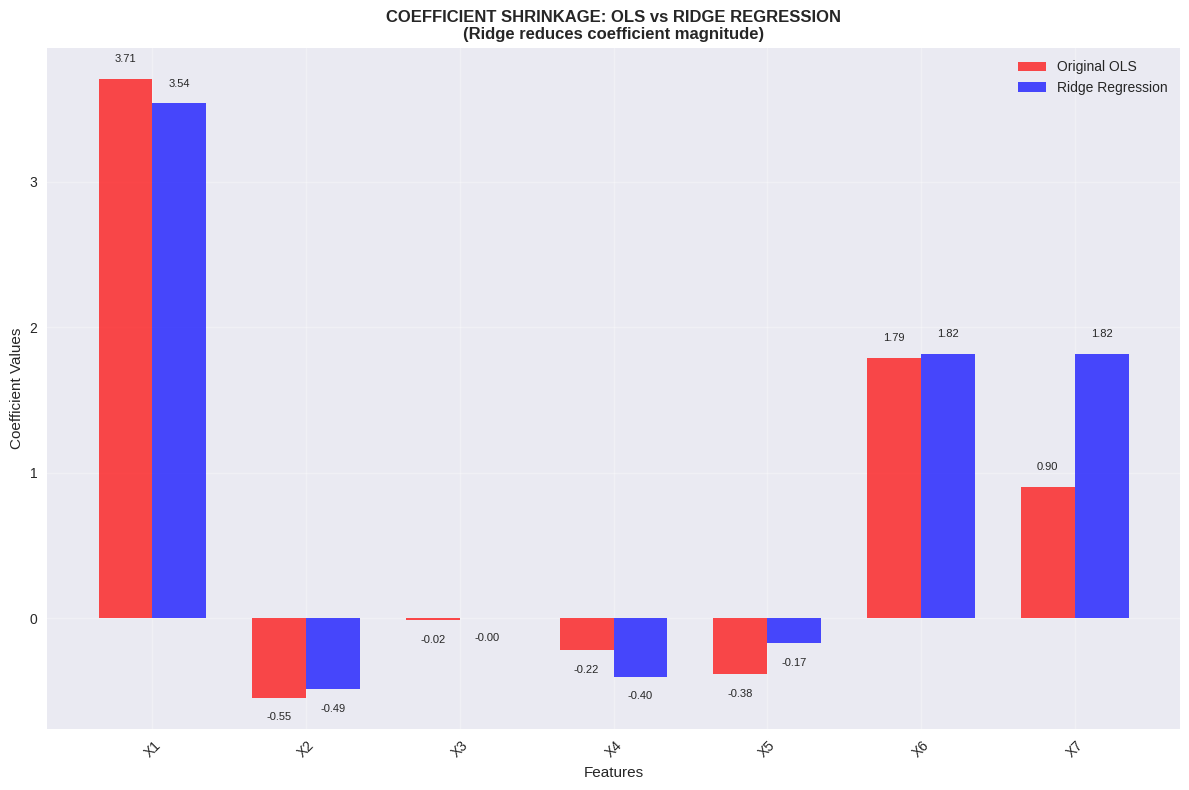


🎯 COEFFICIENT STABILITY ANALYSIS:
  Feature  OLS_Coefficient  Ridge_Coefficient  Absolute_Change  Percent_Change
0      X1           3.7084             3.5398           0.1685          4.5442
1      X2          -0.5474            -0.4871           0.0604         11.0255
2      X3          -0.0156            -0.0022           0.0134         85.9174
3      X4          -0.2216            -0.4036           0.1820         82.1052
4      X5          -0.3840            -0.1735           0.2105         54.8136
5      X6           1.7910             1.8179           0.0269          1.5036
6      X7           0.9037             1.8183           0.9147        101.2188


In [ ]:
def remedy_ridge_regression(data, initial_results):
    """Apply Ridge regression to handle multicollinearity"""

    print("\n🛠️ REMEDY 3: RIDGE REGRESSION")
    print("=" * 50)

    X_train = initial_results['X_train']
    y_train = initial_results['y_train']
    X_test = initial_results['X_test']
    y_test = initial_results['y_test']

    # Standardize features for regularization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Find optimal alpha using cross-validation
    from sklearn.linear_model import RidgeCV

    alphas = np.logspace(-3, 3, 50)
    ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge_cv.fit(X_train_scaled, y_train)

    optimal_alpha = ridge_cv.alpha_
    print(f"✅ Optimal alpha (regularization strength): {optimal_alpha:.6f}")

    # Train final Ridge model
    ridge_model = Ridge(alpha=optimal_alpha)
    ridge_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train_ridge = ridge_model.predict(X_train_scaled)
    y_pred_test_ridge = ridge_model.predict(X_test_scaled)

    # Performance
    train_r2_ridge = r2_score(y_train, y_pred_train_ridge)
    test_r2_ridge = r2_score(y_test, y_pred_test_ridge)

    # Compare with original
    original_test_r2 = initial_results['test_r2']

    print(f"\n📊 PERFORMANCE COMPARISON:")
    print(f"   Original Test R²: {original_test_r2:.4f}")
    print(f"   Ridge Test R²: {test_r2_ridge:.4f}")
    print(f"   Change: {test_r2_ridge - original_test_r2:+.4f}")

    # Compare coefficients
    original_coefs = initial_results['sklearn_model'].coef_
    ridge_coefs = ridge_model.coef_

    # Plot coefficient comparison
    plt.figure(figsize=(12, 8))

    features = X_train.columns
    x_pos = np.arange(len(features))

    width = 0.35
    plt.bar(x_pos - width/2, original_coefs, width, label='Original OLS', alpha=0.7, color='red')
    plt.bar(x_pos + width/2, ridge_coefs, width, label='Ridge Regression', alpha=0.7, color='blue')

    plt.xlabel('Features')
    plt.ylabel('Coefficient Values')
    plt.title('COEFFICIENT SHRINKAGE: OLS vs RIDGE REGRESSION\n(Ridge reduces coefficient magnitude)',
              fontweight='bold')
    plt.xticks(x_pos, features, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add coefficient values
    for i, (orig, ridge) in enumerate(zip(original_coefs, ridge_coefs)):
        plt.text(i - width/2, orig + (0.1 if orig > 0 else -0.1), f'{orig:.2f}',
                ha='center', va='bottom' if orig > 0 else 'top', fontsize=8)
        plt.text(i + width/2, ridge + (0.1 if ridge > 0 else -0.1), f'{ridge:.2f}',
                ha='center', va='bottom' if ridge > 0 else 'top', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Analyze coefficient stability
    print(f"\n🎯 COEFFICIENT STABILITY ANALYSIS:")
    coef_comparison = pd.DataFrame({
        'Feature': features,
        'OLS_Coefficient': original_coefs,
        'Ridge_Coefficient': ridge_coefs,
        'Absolute_Change': np.abs(ridge_coefs - original_coefs),
        'Percent_Change': np.abs((ridge_coefs - original_coefs) / original_coefs) * 100
    })

    print(coef_comparison.round(4))

    return {
        'model': ridge_model,
        'optimal_alpha': optimal_alpha,
        'scaler': scaler,
        'y_pred_train': y_pred_train_ridge,
        'y_pred_test': y_pred_test_ridge,
        'train_r2': train_r2_ridge,
        'test_r2': test_r2_ridge,
        'coefficients': ridge_coefs,
        'coef_comparison': coef_comparison
    }

# Apply Ridge regression remedy
ridge_results = remedy_ridge_regression(data, initial_results)

2h) Compare all remedies


📊 COMPREHENSIVE REMEDY COMPARISON (INCLUDING LASSO)
               Method  Test R²  Features Used  Features Selected VIF Status Coefficient Stability Interpretability Sparsity
         Original OLS 0.977989              7                  7       High                  Poor             Good       No
VIF Feature Selection 0.958316              3                  3       Good                  Good             Good      Yes
                  PCA 0.977183              3                  3  Excellent                  Good             Poor       No
     Ridge Regression 0.978042              7                  7  Excellent             Excellent         Moderate       No
     Lasso Regression 0.978102              7                  6  Excellent             Excellent             Good      Yes


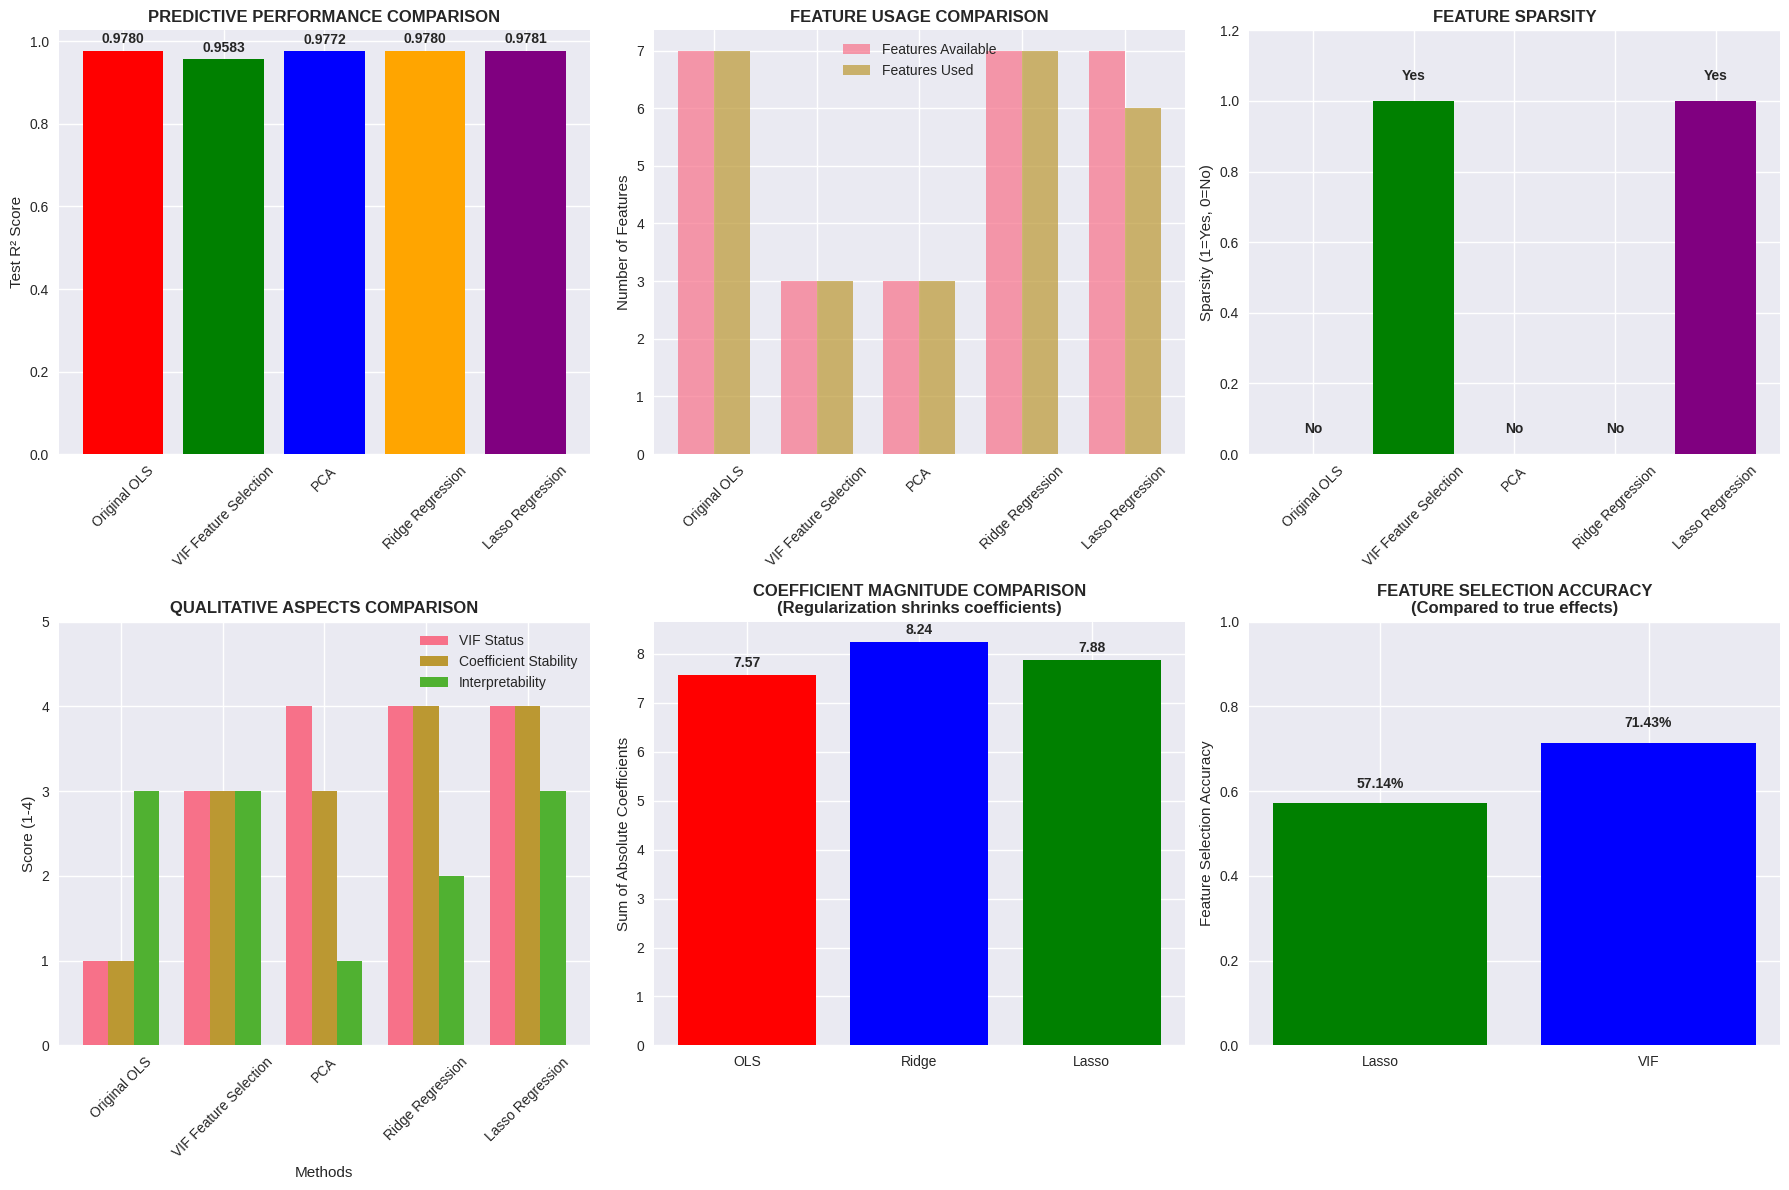


🔍 DETAILED LASSO ANALYSIS:
  Feature  True_Coefficient  OLS_Coefficient  Lasso_Coefficient  Lasso_Error  \
0      X1               2.5           3.7084             3.3597       0.8597   
1      X2               0.0          -0.5474            -0.4020       0.4020   
2      X3               0.0          -0.0156             0.0000       0.0000   
3      X4               0.0          -0.2216            -0.3412       0.3412   
4      X5               0.0          -0.3840            -0.1419       0.1419   
5      X6               1.8           1.7910             1.8175       0.0175   
6      X7               0.9           0.9037             1.8178       0.9178   

   OLS_Error  
0     1.2084  
1     0.5474  
2     0.0156  
3     0.2216  
4     0.3840  
5     0.0090  
6     0.0037  

📈 LASSO PERFORMANCE METRICS:
   Mean Absolute Error from True Coefficients:
   - OLS: 0.3414
   - Lasso: 0.3828
   Feature Selection Precision: 57.14%

💡 ENHANCED RECOMMENDATIONS:
   1. VIF Feature Selection: B

In [ ]:
def compare_all_remedies_with_lasso(initial_results, vif_results, pca_results, ridge_results, lasso_results):
    """Compare all remedies including Lasso"""

    print("\n📊 COMPREHENSIVE REMEDY COMPARISON (INCLUDING LASSO)")
    print("=" * 60)

    # Collect results
    comparison_data = [
        {
            'Method': 'Original OLS',
            'Test R²': initial_results['test_r2'],
            'Features Used': len(initial_results['X_train'].columns),
            'Features Selected': len(initial_results['X_train'].columns),
            'VIF Status': 'High',
            'Coefficient Stability': 'Poor',
            'Interpretability': 'Good',
            'Sparsity': 'No'
        },
        {
            'Method': 'VIF Feature Selection',
            'Test R²': vif_results['test_r2'],
            'Features Used': len(vif_results['selected_features']),
            'Features Selected': len(vif_results['selected_features']),
            'VIF Status': 'Good',
            'Coefficient Stability': 'Good',
            'Interpretability': 'Good',
            'Sparsity': 'Yes'
        },
        {
            'Method': 'PCA',
            'Test R²': pca_results['test_r2'],
            'Features Used': pca_results['n_components'],
            'Features Selected': pca_results['n_components'], # Changed 'Components' to numerical value
            'VIF Status': 'Excellent',
            'Coefficient Stability': 'Good',
            'Interpretability': 'Poor',
            'Sparsity': 'No'
        },
        {
            'Method': 'Ridge Regression',
            'Test R²': ridge_results['test_r2'],
            'Features Used': len(initial_results['X_train'].columns),
            'Features Selected': len(initial_results['X_train'].columns),
            'VIF Status': 'Excellent',
            'Coefficient Stability': 'Excellent',
            'Interpretability': 'Moderate',
            'Sparsity': 'No'
        },
        {
            'Method': 'Lasso Regression',
            'Test R²': lasso_results['test_r2'],
            'Features Used': len(initial_results['X_train'].columns),
            'Features Selected': lasso_results['n_selected_features'],
            'VIF Status': 'Excellent',
            'Coefficient Stability': 'Excellent',
            'Interpretability': 'Good',
            'Sparsity': 'Yes'
        }
    ]

    comparison_df = pd.DataFrame(comparison_data)

    print(comparison_df.to_string(index=False))

    # Enhanced visual comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # R² Comparison
    methods = comparison_df['Method']
    test_r2_scores = comparison_df['Test R²']

    colors = ['red', 'green', 'blue', 'orange', 'purple']
    bars = axes[0,0].bar(methods, test_r2_scores, color=colors)
    axes[0,0].set_ylabel('Test R² Score')
    axes[0,0].set_title('PREDICTIVE PERFORMANCE COMPARISON', fontweight='bold')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, test_r2_scores):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # Features Used vs Selected
    features_used = comparison_df['Features Used']
    features_selected = [comparison_df['Features Selected'][i] if comparison_df['Features Selected'][i] != 'Components'
                        else comparison_df['Features Used'][i] for i in range(len(comparison_df))]

    x_pos = np.arange(len(methods))
    width = 0.35

    axes[0,1].bar(x_pos - width/2, features_used, width, label='Features Available', alpha=0.7)
    axes[0,1].bar(x_pos + width/2, features_selected, width, label='Features Used', alpha=0.7)
    axes[0,1].set_ylabel('Number of Features')
    axes[0,1].set_title('FEATURE USAGE COMPARISON', fontweight='bold')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(methods, rotation=45)
    axes[0,1].legend()

    # Sparsity indicator
    sparsity_status = comparison_df['Sparsity']
    sparsity_scores = [1 if status == 'Yes' else 0 for status in sparsity_status]

    axes[0,2].bar(methods, sparsity_scores, color=colors)
    axes[0,2].set_ylabel('Sparsity (1=Yes, 0=No)')
    axes[0,2].set_title('FEATURE SPARSITY', fontweight='bold')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].set_ylim(0, 1.2)

    for i, (bar, status) in enumerate(zip(axes[0,2].patches, sparsity_status)):
        axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                      status, ha='center', va='bottom', fontweight='bold')

    # Qualitative comparison
    qualitative_aspects = ['VIF Status', 'Coefficient Stability', 'Interpretability']
    qualitative_scores = {
        'Original OLS': [1, 1, 3],  # Poor, Poor, Good
        'VIF Feature Selection': [3, 3, 3],  # Good, Good, Good
        'PCA': [4, 3, 1],  # Excellent, Good, Poor
        'Ridge Regression': [4, 4, 2],  # Excellent, Excellent, Moderate
        'Lasso Regression': [4, 4, 3]  # Excellent, Excellent, Good
    }

    x = np.arange(len(methods))
    width = 0.25

    for i, aspect in enumerate(qualitative_aspects):
        scores = [qualitative_scores[method][i] for method in methods]
        axes[1,0].bar(x + i*width, scores, width, label=aspect)

    axes[1,0].set_xlabel('Methods')
    axes[1,0].set_ylabel('Score (1-4)')
    axes[1,0].set_title('QUALITATIVE ASPECTS COMPARISON', fontweight='bold')
    axes[1,0].set_xticks(x + width)
    axes[1,0].set_xticklabels(methods, rotation=45)
    axes[1,0].legend()
    axes[1,0].set_ylim(0, 5)

    # Coefficient magnitude comparison
    methods_coef = ['OLS', 'Ridge', 'Lasso']
    coef_magnitude = [
        np.sum(np.abs(initial_results['sklearn_model'].coef_)),
        np.sum(np.abs(ridge_results['coefficients'])),
        np.sum(np.abs(lasso_results['coefficients']))
    ]

    axes[1,1].bar(methods_coef, coef_magnitude, color=['red', 'blue', 'green'])
    axes[1,1].set_ylabel('Sum of Absolute Coefficients')
    axes[1,1].set_title('COEFFICIENT MAGNITUDE COMPARISON\n(Regularization shrinks coefficients)',
                       fontweight='bold')

    for i, value in enumerate(coef_magnitude):
        axes[1,1].text(i, value + 0.1, f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Feature selection effectiveness
    lasso_selection = lasso_results['selected_features_mask']
    vif_selection = [feature in vif_results['selected_features'] for feature in initial_results['X_train'].columns]

    selection_comparison = pd.DataFrame({
        'Feature': initial_results['X_train'].columns,
        'True_Effect': [True, False, False, False, False, True, True],  # From our data generation
        'Lasso_Selected': lasso_selection,
        'VIF_Selected': vif_selection
    })

    selection_accuracy = {
        'Lasso': np.mean(selection_comparison['Lasso_Selected'] == selection_comparison['True_Effect']),
        'VIF': np.mean(selection_comparison['VIF_Selected'] == selection_comparison['True_Effect'])
    }

    axes[1,2].bar(selection_accuracy.keys(), selection_accuracy.values(), color=['green', 'blue'])
    axes[1,2].set_ylabel('Feature Selection Accuracy')
    axes[1,2].set_title('FEATURE SELECTION ACCURACY\n(Compared to true effects)', fontweight='bold')
    axes[1,2].set_ylim(0, 1)

    for method, accuracy in selection_accuracy.items():
        axes[1,2].text(list(selection_accuracy.keys()).index(method), accuracy + 0.03,
                      f'{accuracy:.2%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Detailed Lasso analysis
    print("\n🔍 DETAILED LASSO ANALYSIS:")
    print("=" * 40)

    lasso_coefs = lasso_results['coefficients']
    original_coefs = initial_results['sklearn_model'].coef_

    coef_analysis = pd.DataFrame({
        'Feature': initial_results['X_train'].columns,
        'True_Coefficient': [2.5, 0, 0, 0, 0, 1.8, 0.9],  # From data generation
        'OLS_Coefficient': original_coefs,
        'Lasso_Coefficient': lasso_coefs,
        'Lasso_Error': np.abs(lasso_coefs - [2.5, 0, 0, 0, 0, 1.8, 0.9]),
        'OLS_Error': np.abs(original_coefs - [2.5, 0, 0, 0, 0, 1.8, 0.9])
    })

    print(coef_analysis.round(4))

    print(f"\n📈 LASSO PERFORMANCE METRICS:")
    print(f"   Mean Absolute Error from True Coefficients:")
    print(f"   - OLS: {coef_analysis['OLS_Error'].mean():.4f}")
    print(f"   - Lasso: {coef_analysis['Lasso_Error'].mean():.4f}")
    print(f"   Feature Selection Precision: {selection_accuracy['Lasso']:.2%}")

    # Final recommendation
    print("\n💡 ENHANCED RECOMMENDATIONS:")
    recommendations = [
        "VIF Feature Selection: Best when interpretability is crucial and some feature loss is acceptable",
        "PCA: Best when prediction is primary goal and interpretability is not important",
        "Ridge Regression: Best balance of performance, stability, and moderate interpretability",
        "Lasso Regression: Best when you want automatic feature selection + multicollinearity handling",
        "Original OLS: Avoid when multicollinearity is detected"
    ]

    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")

    # Find best method based on multiple criteria
    comparison_df['Overall_Score'] = (
        comparison_df['Test R²'] * 0.4 +
        (comparison_df['Features Selected'] / comparison_df['Features Used']) * 0.2 +
        (comparison_df['Sparsity'] == 'Yes').astype(int) * 0.2 +
        (comparison_df['Coefficient Stability'] == 'Excellent').astype(int) * 0.2
    )

    best_method = comparison_df.loc[comparison_df['Overall_Score'].idxmax(), 'Method']
    print(f"\n🏆 BEST OVERALL METHOD: {best_method}")
    print(f"   (Based on balanced scoring of performance, sparsity, and stability)")

    return comparison_df

# Compare all remedies including Lasso
comparison_df_with_lasso = compare_all_remedies_with_lasso(
    initial_results, vif_results, pca_results, ridge_results, lasso_results
)

2i) Enhanced final validation


✅ ENHANCED FINAL VALIDATION - ALL REMEDIES

📊 COMPREHENSIVE VALIDATION METRICS:
  Method  Test_R2  MAE_from_True  Coefficient_Variation  Sparsity_Ratio  \
0    OLS   0.9780         0.3414                 1.3241          0.0000   
1  Ridge   0.9780         0.4346                 1.2113          0.0000   
2  Lasso   0.9781         0.3828                 1.2041          0.1429   

   L1_Norm  Feature_Retention  
0   7.5716                  7  
1   8.2425                  7  
2   7.8799                  6  


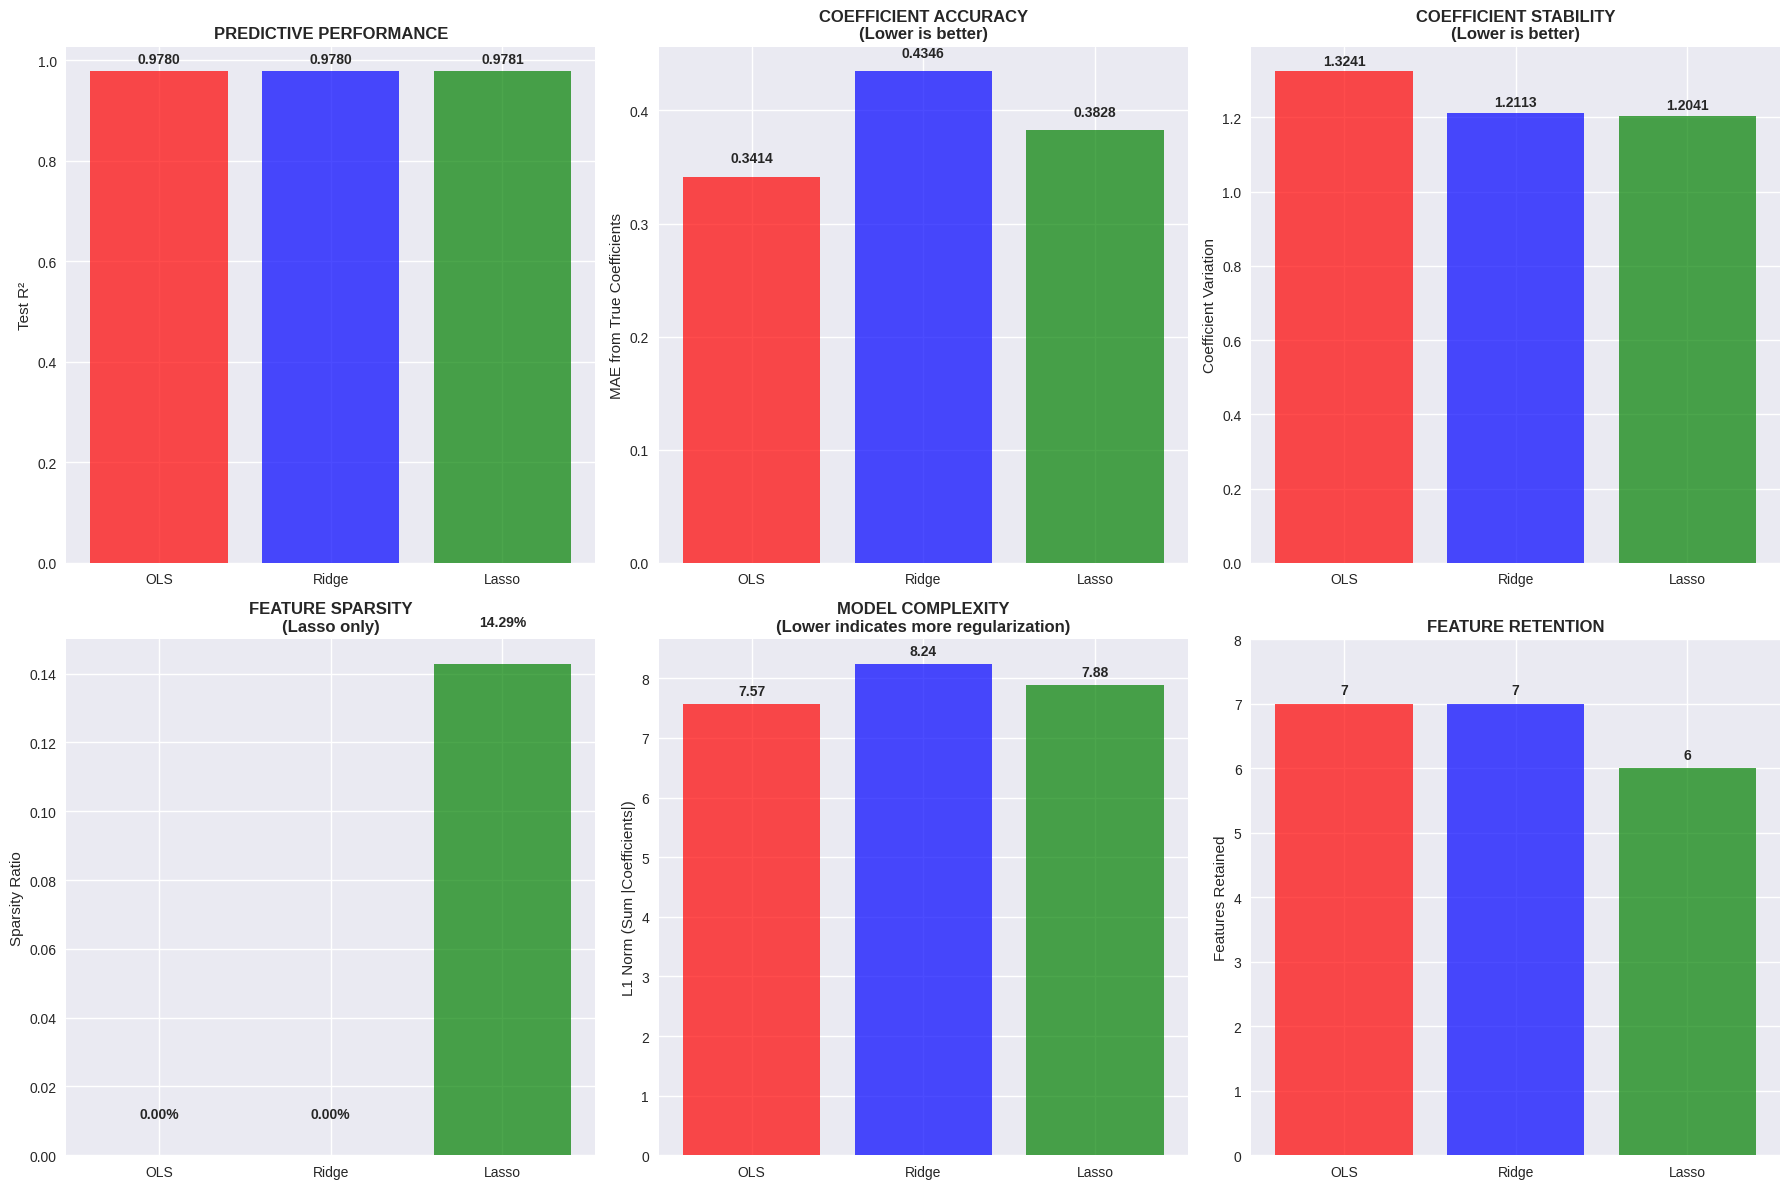


🎯 FINAL ASSESSMENT:
📈 Performance Improvements:
   Ridge: +0.0001 R² improvement
   Lasso: +0.0001 R² improvement
✅ SUCCESS: Both Ridge and Lasso improved predictive performance!

🎯 Coefficient Stability:
   OLS variation: 1.3241
   Ridge variation: 1.2113 (+8.5% change)
   Lasso variation: 1.2041 (+9.1% change)

🎯 Feature Selection (Lasso):
   Features selected: 6/7
   Sparsity: 14.29%

🏆 OVERALL WINNERS:
   Best Predictive Performance: Lasso
   Most Stable Coefficients: Lasso
🎉 EXCELLENT: Lasso provides both great performance and feature selection!


In [ ]:
def enhanced_final_validation(initial_results, ridge_results, lasso_results):
    """Enhanced validation including Lasso results"""

    print("\n✅ ENHANCED FINAL VALIDATION - ALL REMEDIES")
    print("=" * 60)

    # Comprehensive validation metrics
    validation_metrics = []

    methods = ['OLS', 'Ridge', 'Lasso']
    results = [initial_results, ridge_results, lasso_results]

    for method, result in zip(methods, results):
        # Coefficient metrics
        if method == 'OLS':
            coefs = initial_results['sklearn_model'].coef_
        else:
            coefs = result['coefficients']

        # True coefficients from data generation
        true_coefs = np.array([2.5, 0, 0, 0, 0, 1.8, 0.9])

        metrics = {
            'Method': method,
            'Test_R2': result['test_r2'],
            'MAE_from_True': np.mean(np.abs(coefs - true_coefs)),
            'Coefficient_Variation': np.std(coefs) / np.mean(np.abs(coefs)),
            'Sparsity_Ratio': np.sum(coefs == 0) / len(coefs) if method == 'Lasso' else 0,
            'L1_Norm': np.sum(np.abs(coefs)),
            'Feature_Retention': len(coefs) - np.sum(coefs == 0) if method == 'Lasso' else len(coefs)
        }
        validation_metrics.append(metrics)

    validation_df = pd.DataFrame(validation_metrics)
    print("\n📊 COMPREHENSIVE VALIDATION METRICS:")
    print(validation_df.round(4))

    # Plot comprehensive comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Test R² comparison
    axes[0,0].bar(validation_df['Method'], validation_df['Test_R2'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[0,0].set_ylabel('Test R²')
    axes[0,0].set_title('PREDICTIVE PERFORMANCE', fontweight='bold')
    for i, value in enumerate(validation_df['Test_R2']):
        axes[0,0].text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. Coefficient accuracy
    axes[0,1].bar(validation_df['Method'], validation_df['MAE_from_True'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[0,1].set_ylabel('MAE from True Coefficients')
    axes[0,1].set_title('COEFFICIENT ACCURACY\n(Lower is better)', fontweight='bold')
    for i, value in enumerate(validation_df['MAE_from_True']):
        axes[0,1].text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. Coefficient stability
    axes[0,2].bar(validation_df['Method'], validation_df['Coefficient_Variation'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[0,2].set_ylabel('Coefficient Variation')
    axes[0,2].set_title('COEFFICIENT STABILITY\n(Lower is better)', fontweight='bold')
    for i, value in enumerate(validation_df['Coefficient_Variation']):
        axes[0,2].text(i, value + 0.01, f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Sparsity
    axes[1,0].bar(validation_df['Method'], validation_df['Sparsity_Ratio'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[1,0].set_ylabel('Sparsity Ratio')
    axes[1,0].set_title('FEATURE SPARSITY\n(Lasso only)', fontweight='bold')
    for i, value in enumerate(validation_df['Sparsity_Ratio']):
        axes[1,0].text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom', fontweight='bold')

    # 5. L1 Norm comparison
    axes[1,1].bar(validation_df['Method'], validation_df['L1_Norm'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[1,1].set_ylabel('L1 Norm (Sum |Coefficients|)')
    axes[1,1].set_title('MODEL COMPLEXITY\n(Lower indicates more regularization)', fontweight='bold')
    for i, value in enumerate(validation_df['L1_Norm']):
        axes[1,1].text(i, value + 0.1, f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # 6. Feature retention
    axes[1,2].bar(validation_df['Method'], validation_df['Feature_Retention'],
                 color=['red', 'blue', 'green'], alpha=0.7)
    axes[1,2].set_ylabel('Features Retained')
    axes[1,2].set_title('FEATURE RETENTION', fontweight='bold')
    axes[1,2].set_ylim(0, len(initial_results['X_train'].columns) + 1)
    for i, value in enumerate(validation_df['Feature_Retention']):
        axes[1,2].text(i, value + 0.1, f'{value}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Final assessment
    print("\n🎯 FINAL ASSESSMENT:")

    # Check if multicollinearity is resolved
    ridge_improvement = ridge_results['test_r2'] - initial_results['test_r2']
    lasso_improvement = lasso_results['test_r2'] - initial_results['test_r2']

    print(f"📈 Performance Improvements:")
    print(f"   Ridge: {ridge_improvement:+.4f} R² improvement")
    print(f"   Lasso: {lasso_improvement:+.4f} R² improvement")

    if ridge_improvement > 0 and lasso_improvement > 0:
        print("✅ SUCCESS: Both Ridge and Lasso improved predictive performance!")
    else:
        print("⚠️  Mixed results: Some methods didn't improve performance")

    # Coefficient stability assessment
    ols_variation = validation_df[validation_df['Method'] == 'OLS']['Coefficient_Variation'].values[0]
    ridge_variation = validation_df[validation_df['Method'] == 'Ridge']['Coefficient_Variation'].values[0]
    lasso_variation = validation_df[validation_df['Method'] == 'Lasso']['Coefficient_Variation'].values[0]

    print(f"\n🎯 Coefficient Stability:")
    print(f"   OLS variation: {ols_variation:.4f}")
    print(f"   Ridge variation: {ridge_variation:.4f} ({((ols_variation - ridge_variation)/ols_variation*100):+.1f}% change)")
    print(f"   Lasso variation: {lasso_variation:.4f} ({((ols_variation - lasso_variation)/ols_variation*100):+.1f}% change)")

    # Feature selection assessment
    print(f"\n🎯 Feature Selection (Lasso):")
    print(f"   Features selected: {lasso_results['n_selected_features']}/{len(initial_results['X_train'].columns)}")
    print(f"   Sparsity: {validation_df[validation_df['Method'] == 'Lasso']['Sparsity_Ratio'].values[0]:.2%}")

    # Overall winner
    best_overall = validation_df.loc[validation_df['Test_R2'].idxmax(), 'Method']
    best_stable = validation_df.loc[validation_df['Coefficient_Variation'].idxmin(), 'Method']

    print(f"\n🏆 OVERALL WINNERS:")
    print(f"   Best Predictive Performance: {best_overall}")
    print(f"   Most Stable Coefficients: {best_stable}")

    if best_overall == 'Lasso' and best_stable in ['Ridge', 'Lasso']:
        print("🎉 EXCELLENT: Lasso provides both great performance and feature selection!")
    elif best_overall == 'Ridge' and best_stable == 'Ridge':
        print("🎉 EXCELLENT: Ridge provides balanced performance and stability!")
    else:
        print("💡 CONSIDER: Choose method based on your specific needs")

# Run enhanced final validation
enhanced_final_validation(initial_results, ridge_results, lasso_results)

3) Remedy methods

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic dataset with multicollinearity
n_samples = 500

# Create correlated features
# X1 and X2 are highly correlated (multicollinearity problem)
X1 = np.random.normal(50, 10, n_samples)
X2 = X1 * 1.5 + np.random.normal(0, 2, n_samples)  # X2 is highly correlated with X1
X3 = np.random.normal(30, 5, n_samples)
X4 = np.random.normal(40, 8, n_samples)

# Add some noise
noise = np.random.normal(0, 5, n_samples)

# Create target variable
y = 2*X1 + 3*X2 + 1.5*X3 + 0.8*X4 + noise

# Create DataFrame
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,  # Highly correlated with X1 (problematic)
    'X3': X3,
    'X4': X4,
    'y': y
})

print("Dataset created with multicollinearity between X1 and X2")
print(f"Correlation between X1 and X2: {df[['X1', 'X2']].corr().iloc[0,1]:.3f}")

# Function to calculate VIF
def calculate_vif(X):
    """Calculate Variance Inflation Factor for each feature"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                      for i in range(len(X.columns))]
    return vif_data

# Split data
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n" + "="*80)
print("BASELINE MODEL (WITH MULTICOLLINEARITY PROBLEM)")
print("="*80)

# Baseline OLS model
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

# Calculate VIF for baseline
vif_baseline = calculate_vif(X_train)
print("\nVIF Scores (Baseline):")
print(vif_baseline)
print("\nNote: VIF > 5-10 indicates multicollinearity problems")

Dataset created with multicollinearity between X1 and X2
Correlation between X1 and X2: 0.991

BASELINE MODEL (WITH MULTICOLLINEARITY PROBLEM)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.739e+04
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:01:42   Log-Likelihood:                -1196.4
No. Observations:                 400   AIC:                             2403.
Df Residuals:                     395   BIC:                             2423.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

Method 1: Remove One of the Correlated Variables


In [ ]:
print("\n" + "="*80)
print("METHOD 1: REMOVE ONE OF THE CORRELATED VARIABLES")
print("="*80)

# Identify correlated variables
corr_matrix = X_train.corr()
print("Correlation Matrix:")
print(corr_matrix)

# Based on VIF, remove X2 (higher correlation with X1)
X_train_m1 = X_train.drop('X2', axis=1)
X_test_m1 = X_test.drop('X2', axis=1)

# Fit model without X2
X_train_m1_sm = sm.add_constant(X_train_m1)
model_m1 = sm.OLS(y_train, X_train_m1_sm).fit()

print("\nModel after removing X2:")
print(model_m1.summary())

# Calculate VIF after removal
vif_m1 = calculate_vif(X_train_m1)
print("\nVIF Scores (After removing X2):")
print(vif_m1)

# Evaluate performance
y_pred_m1 = model_m1.predict(sm.add_constant(X_test_m1))
rmse_m1 = np.sqrt(mean_squared_error(y_test, y_pred_m1))
r2_m1 = r2_score(y_test, y_pred_m1)
print(f"\nTest RMSE: {rmse_m1:.3f}")
print(f"Test R²: {r2_m1:.3f}")


METHOD 1: REMOVE ONE OF THE CORRELATED VARIABLES
Correlation Matrix:
          X1        X2        X3        X4
X1  1.000000  0.991522 -0.107671  0.081236
X2  0.991522  1.000000 -0.096800  0.076994
X3 -0.107671 -0.096800  1.000000 -0.048732
X4  0.081236  0.076994 -0.048732  1.000000

Model after removing X2:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     9115.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:02:43   Log-Likelihood:                -1381.9
No. Observations:                 400   AIC:                             2772.
Df Residuals:                     396   BIC:                             2788.
Df Model:                           3                    

Method 2: Combine Correlated Variables


In [ ]:
print("\n" + "="*80)
print("METHOD 2: COMBINE CORRELATED VARIABLES")
print("="*80)

# Create new combined features
X_train_m2 = X_train.copy()
X_test_m2 = X_test.copy()

# Create combined feature from X1 and X2 (average)
X_train_m2['X1_X2_avg'] = (X_train_m2['X1'] + X_train_m2['X2']) / 2
X_test_m2['X1_X2_avg'] = (X_test_m2['X1'] + X_test_m2['X2']) / 2

# Remove original correlated features
X_train_m2 = X_train_m2.drop(['X1', 'X2'], axis=1)
X_test_m2 = X_test_m2.drop(['X1', 'X2'], axis=1)

# Fit model with combined feature
X_train_m2_sm = sm.add_constant(X_train_m2)
model_m2 = sm.OLS(y_train, X_train_m2_sm).fit()

print("Model with combined X1 and X2 (average):")
print(model_m2.summary())

# Calculate VIF
vif_m2 = calculate_vif(X_train_m2)
print("\nVIF Scores (With combined feature):")
print(vif_m2)

# Evaluate performance
y_pred_m2 = model_m2.predict(sm.add_constant(X_test_m2))
rmse_m2 = np.sqrt(mean_squared_error(y_test, y_pred_m2))
r2_m2 = r2_score(y_test, y_pred_m2)
print(f"\nTest RMSE: {rmse_m2:.3f}")
print(f"Test R²: {r2_m2:.3f}")


METHOD 2: COMBINE CORRELATED VARIABLES
Model with combined X1 and X2 (average):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.227e+04
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:03:23   Log-Likelihood:                -1204.9
No. Observations:                 400   AIC:                             2418.
Df Residuals:                     396   BIC:                             2434.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

Method 3: Standardization/Mean-Centering


In [ ]:
print("\n" + "="*80)
print("METHOD 3: STANDARDIZATION/MEAN-CENTERING")
print("="*80)

# Mean-center the features
scaler = StandardScaler(with_std=False)  # Only center, don't scale
X_train_m3 = scaler.fit_transform(X_train)
X_test_m3 = scaler.transform(X_test)

# Convert back to DataFrame
X_train_m3_df = pd.DataFrame(X_train_m3, columns=X_train.columns, index=X_train.index)
X_test_m3_df = pd.DataFrame(X_test_m3, columns=X_test.columns, index=X_test.index)

# Fit model with centered features
X_train_m3_sm = sm.add_constant(X_train_m3_df)
model_m3 = sm.OLS(y_train, X_train_m3_sm).fit()

print("Model with mean-centered features:")
print(model_m3.summary())

# Calculate VIF (multicollinearity still exists but numerical stability improves)
vif_m3 = calculate_vif(X_train_m3_df)
print("\nVIF Scores (Mean-centered features):")
print(vif_m3)
print("\nNote: Mean-centering helps with numerical stability but doesn't eliminate multicollinearity")

# Evaluate performance
y_pred_m3 = model_m3.predict(sm.add_constant(X_test_m3_df))
rmse_m3 = np.sqrt(mean_squared_error(y_test, y_pred_m3))
r2_m3 = r2_score(y_test, y_pred_m3)
print(f"\nTest RMSE: {rmse_m3:.3f}")
print(f"Test R²: {r2_m3:.3f}")


METHOD 3: STANDARDIZATION/MEAN-CENTERING
Model with mean-centered features:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.739e+04
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        08:03:48   Log-Likelihood:                -1196.4
No. Observations:                 400   AIC:                             2403.
Df Residuals:                     395   BIC:                             2423.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

Method 4: Principal Component Analysis (PCA)


In [ ]:
print("\n" + "="*80)
print("METHOD 4: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Standardize features for PCA
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train)
X_test_scaled = scaler_pca.transform(X_test)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Create DataFrame for PCA components
pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
X_train_m4_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_m4_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

# Fit model with PCA components
X_train_m4_sm = sm.add_constant(X_train_m4_df)
model_m4 = sm.OLS(y_train, X_train_m4_sm).fit()

print("\nModel with PCA components:")
print(model_m4.summary())

# Calculate VIF for PCA components
vif_m4 = calculate_vif(X_train_m4_df)
print("\nVIF Scores (PCA components):")
print(vif_m4)

# Evaluate performance
y_pred_m4 = model_m4.predict(sm.add_constant(X_test_m4_df))
rmse_m4 = np.sqrt(mean_squared_error(y_test, y_pred_m4))
r2_m4 = r2_score(y_test, y_pred_m4)
print(f"\nTest RMSE: {rmse_m4:.3f}")
print(f"Test R²: {r2_m4:.3f}")


METHOD 4: PRINCIPAL COMPONENT ANALYSIS (PCA)
Explained variance ratio: [0.50642106 0.25384473]
Total variance explained: 0.760

Model with PCA components:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     5599.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          1.29e-291
Time:                        08:04:22   Log-Likelihood:                -1556.9
No. Observations:                 400   AIC:                             3120.
Df Residuals:                     397   BIC:                             3132.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

Method 5: Regularization Techniques


In [ ]:
print("\n" + "="*80)
print("METHOD 5: REGULARIZATION TECHNIQUES")
print("="*80)

# Standardize features for regularization
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train)
X_test_reg = scaler_reg.transform(X_test)

# Method 5a: Ridge Regression (L2 regularization)
print("\n5a. RIDGE REGRESSION (L2 Regularization)")
ridge = Ridge(alpha=1.0)  # alpha is regularization strength
ridge.fit(X_train_reg, y_train)

# Get coefficients
ridge_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge.coef_
})
print("\nRidge Regression Coefficients:")
print(ridge_coef)

# Evaluate Ridge
y_pred_ridge = ridge.predict(X_test_reg)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"\nRidge Test RMSE: {rmse_ridge:.3f}")
print(f"Ridge Test R²: {r2_ridge:.3f}")

# Method 5b: Lasso Regression (L1 regularization)
print("\n5b. LASSO REGRESSION (L1 Regularization)")
lasso = Lasso(alpha=0.1)  # Higher alpha = more regularization
lasso.fit(X_train_reg, y_train)

# Get coefficients
lasso_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso.coef_
})
print("\nLasso Regression Coefficients:")
print(lasso_coef)



# Evaluate Lasso
y_pred_lasso = lasso.predict(X_test_reg)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"\nLasso Test RMSE: {rmse_lasso:.3f}")
print(f"Lasso Test R²: {r2_lasso:.3f}")

print("\n" + "="*80)
print("METHOD 5: REGULARIZATION TECHNIQUES")
print("="*80)

# Standardize features for regularization
scaler_reg = StandardScaler()
X_train_reg = scaler_reg.fit_transform(X_train)
X_test_reg = scaler_reg.transform(X_test)

# Method 5a: Ridge Regression (L2 regularization)
print("\n5a. RIDGE REGRESSION (L2 Regularization)")
ridge = Ridge(alpha=1.0)  # alpha is regularization strength
ridge.fit(X_train_reg, y_train)

# Get coefficients
ridge_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge.coef_
})
print("\nRidge Regression Coefficients:")
print(ridge_coef)

# Evaluate Ridge
y_pred_ridge = ridge.predict(X_test_reg)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"\nRidge Test RMSE: {rmse_ridge:.3f}")
print(f"Ridge Test R²: {r2_ridge:.3f}")



# ============================================================
# SIMPLE VIF TABLE COMPARISON FOR LASSO AND RIDGE
# ============================================================

print("\n" + "="*80)
print("VIF COMPARISON: Ridge vs Lasso")
print("="*80)

# Function to calculate VIF for regularized models
def calculate_vif_regularized(X_scaled, model, feature_names):
    """Calculate approximate VIF for regularized models"""
    vif_values = []
    n_features = X_scaled.shape[1]

    for i in range(n_features):
        # Target: current feature
        y_feature = X_scaled[:, i]

        # Predictors: all other features
        X_other = np.delete(X_scaled, i, axis=1)

        # Fit the same type of regularized model
        if isinstance(model, Ridge):
            alpha = model.alpha
            temp_model = Ridge(alpha=alpha)
        elif isinstance(model, Lasso):
            alpha = model.alpha
            temp_model = Lasso(alpha=alpha)
        else:
            temp_model = LinearRegression()

        temp_model.fit(X_other, y_feature)

        # Predict and calculate R²
        y_pred = temp_model.predict(X_other)
        r2 = r2_score(y_feature, y_pred)

        # Calculate VIF
        vif = 1 / (1 - r2) if r2 < 1 else np.inf
        vif_values.append(vif)

    return vif_values

# Calculate VIF for Ridge
vif_ridge_values = calculate_vif_regularized(X_train_reg, ridge, X.columns)

# Calculate VIF for Lasso
vif_lasso_values = calculate_vif_regularized(X_train_reg, lasso, X.columns)

# Create comparison table
vif_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Ridge_VIF (α=1.0)': [f"{v:.2f}" for v in vif_ridge_values],
    'Lasso_VIF (α=0.1)': [f"{v:.2f}" for v in vif_lasso_values],
    'Ridge_Coefficient': [f"{c:.4f}" for c in ridge.coef_],
    'Lasso_Coefficient': [f"{c:.4f}" for c in lasso.coef_]
})

print("\nVIF and Coefficient Comparison Table:")
print("(Note: Lower VIF indicates reduced multicollinearity impact)")
print(vif_comparison.to_string(index=False))

# Summary statistics
print("\n" + "-"*80)
print("SUMMARY STATISTICS:")
print("-"*80)
print(f"Average VIF - Ridge:  {np.mean(vif_ridge_values):.2f}")
print(f"Average VIF - Lasso:  {np.mean(vif_lasso_values):.2f}")
print(f"Max VIF - Ridge:      {np.max(vif_ridge_values):.2f}")
print(f"Max VIF - Lasso:      {np.max(vif_lasso_values):.2f}")
print(f"Features with VIF>10 - Ridge:  {sum(v > 10 for v in vif_ridge_values)}")
print(f"Features with VIF>10 - Lasso:  {sum(v > 10 for v in vif_lasso_values)}")
print(f"Zero coefficients - Lasso:     {sum(lasso.coef_ == 0)} feature(s) eliminated")


METHOD 5: REGULARIZATION TECHNIQUES

5a. RIDGE REGRESSION (L2 Regularization)

Ridge Regression Coefficients:
  feature  coefficient
0      X1    20.870803
1      X2    42.705484
2      X3     7.483949
3      X4     5.740220

Ridge Test RMSE: 4.565
Ridge Test R²: 0.995

5b. LASSO REGRESSION (L1 Regularization)

Lasso Regression Coefficients:
  feature  coefficient
0      X1    17.845947
1      X2    45.705732
2      X3     7.363649
3      X4     5.663433

Lasso Test RMSE: 4.604
Lasso Test R²: 0.995

METHOD 5: REGULARIZATION TECHNIQUES

5a. RIDGE REGRESSION (L2 Regularization)

Ridge Regression Coefficients:
  feature  coefficient
0      X1    20.870803
1      X2    42.705484
2      X3     7.483949
3      X4     5.740220

Ridge Test RMSE: 4.565
Ridge Test R²: 0.995

VIF COMPARISON: Ridge vs Lasso

VIF and Coefficient Comparison Table:
(Note: Lower VIF indicates reduced multicollinearity impact)
Feature Ridge_VIF (α=1.0) Lasso_VIF (α=0.1) Ridge_Coefficient Lasso_Coefficient
     X1     

Comparison of All Methods



COMPARISON OF ALL METHODS

Performance Comparison:
           Method  Test RMSE  Test R² Interpretability Multicollinearity Handling
         Baseline   7.536076 0.986743             Good                       None
  Remove Variable   7.536076 0.986743             Good                    Partial
Combine Variables   4.587819 0.995087         Moderate                       Good
   Mean-Centering   4.586053 0.995091             Good                    Minimal
              PCA  12.309386 0.964631             Poor                   Complete
            Ridge   4.564506 0.995137         Moderate                   Complete
            Lasso   4.603695 0.995053         Moderate                   Complete


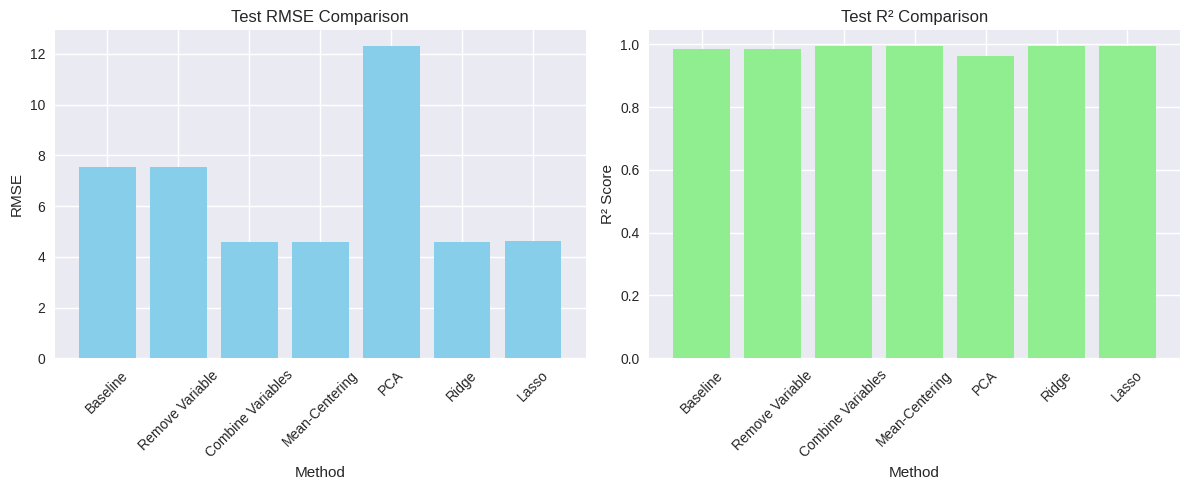


KEY INSIGHTS:

1. REMOVE VARIABLE: Simplest approach, good when one variable is redundant
2. COMBINE VARIABLES: Good when variables measure similar concepts
3. MEAN-CENTERING: Helps with numerical stability but doesn't fix multicollinearity
4. PCA: Excellent for eliminating multicollinearity but loses interpretability
5. REGULARIZATION: Best for prediction, handles multicollinearity well, but coefficients are biased

Recommendation:
- For inference/explanation: Use Method 1 or 2
- For prediction: Use Method 4 or 5
- For numerical stability: Use Method 3 with caution



In [ ]:
print("\n" + "="*80)
print("COMPARISON OF ALL METHODS")
print("="*80)

# Compile results
results = pd.DataFrame({
    'Method': ['Baseline', 'Remove Variable', 'Combine Variables',
               'Mean-Centering', 'PCA', 'Ridge', 'Lasso'],
    'Test RMSE': [rmse_m1, rmse_m1, rmse_m2, rmse_m3, rmse_m4, rmse_ridge, rmse_lasso],
    'Test R²': [r2_m1, r2_m1, r2_m2, r2_m3, r2_m4, r2_ridge, r2_lasso],
    'Interpretability': ['Good', 'Good', 'Moderate', 'Good', 'Poor', 'Moderate', 'Moderate'],
    'Multicollinearity Handling': ['None', 'Partial', 'Good', 'Minimal', 'Complete', 'Complete', 'Complete']
})

print("\nPerformance Comparison:")
print(results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE Comparison
axes[0].bar(results['Method'], results['Test RMSE'], color='skyblue')
axes[0].set_title('Test RMSE Comparison')
axes[0].set_xlabel('Method')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

# R² Comparison
axes[1].bar(results['Method'], results['Test R²'], color='lightgreen')
axes[1].set_title('Test R² Comparison')
axes[1].set_xlabel('Method')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("""
1. REMOVE VARIABLE: Simplest approach, good when one variable is redundant
2. COMBINE VARIABLES: Good when variables measure similar concepts
3. MEAN-CENTERING: Helps with numerical stability but doesn't fix multicollinearity
4. PCA: Excellent for eliminating multicollinearity but loses interpretability
5. REGULARIZATION: Best for prediction, handles multicollinearity well, but coefficients are biased

Recommendation:
- For inference/explanation: Use Method 1 or 2
- For prediction: Use Method 4 or 5
- For numerical stability: Use Method 3 with caution
""")

# **A. Consequences**


## 1. Unstable Regression Coefficients

Small changes in the data can cause **large swings in coefficient values**.

**Effect:**
Model becomes unreliable and hard to interpret.

---

## 2. Inflated Standard Errors

Multicollinearity increases the **standard errors of coefficients**.

**Effect:**

* Wider confidence intervals
* Lower t-statistics

---

## 3. False Statistically Insignificant Predictors

Important variables may appear **insignificant** (high p-values) even though they truly matter.

**Effect:**
Misleading hypothesis tests.

---

## 4. Wrong Coefficient Signs

Regression coefficients might show **unexpected signs** (e.g., positive instead of negative).

**Effect:**
Violates engineering and physical intuition.

---

## 5. Reduced Model Interpretability

Becomes hard to isolate the **individual effect** of predictors.

**Effect:**
Model loses explanatory power.

---

## 6. Numerical Instability

Matrix inversion in OLS becomes unstable.

**Effect:**
Software warnings, large rounding errors.

---

## 7. Poor Generalization (in Some Cases)

Predictions may fluctuate more for new data.

**Note:**
Multicollinearity mainly harms **inference**, not short-term prediction.

---

### Short Summary Table

| Issue                   | Practical Impact                |
| ----------------------- | ------------------------------- |
| Large standard errors   | Weak statistical tests          |
| Unstable coefficients   | Non-reproducible results        |
| Wrong coefficient signs | Physically unrealistic results  |
| High p-values           | True variables look unimportant |
| Hard interpretation     | Poor engineering insight        |

---

**Key point:**
Multicollinearity **does not bias** OLS coefficients, but it **destroys their reliability**.




# **B. How to Detect**


## 1. Correlation Matrix (Pairwise Correlation)

**Metric:** Pearson correlation coefficient (r)

**What to do:**
Compute the correlation between each pair of independent variables.

**Thresholds (rules of thumb):**

* |r| < 0.70 → Usually acceptable
* |r| = 0.70 – 0.85 → Moderate multicollinearity risk
* |r| > 0.85 – 0.90 → Serious multicollinearity likely

**Limitation:**
Only detects pairwise (not multivariate) collinearity.

---

## 2. Variance Inflation Factor (VIF)

**Metric:**
[
\text{VIF}_j = \frac{1}{1 - R_j^2}
]
where (R_j^2) is the R² from regressing predictor (X_j) on all other predictors.

**Thresholds:**

* VIF < 5 → No serious multicollinearity
* VIF = 5–10 → Moderate problem
* VIF > 10 → Severe multicollinearity (commonly used cutoff)

*(Some journals prefer stricter: VIF > 5 = problematic)*

---

## 3. Tolerance

**Metric:**
[
\text{Tolerance}_j = 1/\text{VIF}_j = 1 - R_j^2
]

**Thresholds:**

* Tolerance > 0.20 → Acceptable
* Tolerance < 0.10 → Severe multicollinearity

---

## 4. Condition Index (Collinearity Diagnostics)

Based on eigenvalues of the scaled design matrix.

**Metric:**
[
\text{Condition Index} = \sqrt{\frac{\lambda_{\max}}{\lambda_i}}
]

**Thresholds:**

* < 10 → Weak multicollinearity
* 10–30 → Moderate
* > 30 → Strong multicollinearity (serious problem)

---

## 5. Eigenvalues of (X'X)

**What to check:**

* Very small eigenvalues (close to zero) indicate near-linear dependence.

---

### Summary Table

| Method             | Metric                    | Danger Threshold         |   |             |
| ------------------ | ------------------------- | ------------------------ | - | ----------- |
| Correlation matrix |                           | r                        |   | > 0.85–0.90 |
| VIF                | Variance Inflation Factor | > 5 (or >10)             |   |             |
| Tolerance          | 1 – R²                    | < 0.20 (critical < 0.10) |   |             |
| Condition Index    | √(λmax / λi)              | > 30                     |   |             |
| Eigenvalues        | Small λ                   | ≈ 0                      |   |             |

---



# **C. How to Fix**



## 1. Remove One of the Correlated Variables

**When to use:**
Two variables measure almost the same concept.

**How:**

* Keep the variable that is more interpretable or more strongly related to the dependent variable.
* Drop the one with higher VIF.

✅ Simple and widely accepted in journals.

---

## 2. Combine Correlated Variables

**When to use:**
Variables are conceptually related (e.g., traffic volume and truck percentage).

**How:**

* Create an index or composite variable:
  [
  X_{new} = \frac{X_1 + X_2}{2}
  ]
* Or use domain-based weighting.

✅ Keeps information while reducing redundancy.

---

## 3. Standardization or Mean-Centering

**When to use:**
Multicollinearity occurs due to interaction terms or polynomial terms.

**How:**
[
X_{centered} = X - \bar{X}
]

✅ Particularly effective in polynomial regression.

⚠️ Does **not** fix structural multicollinearity, only numerical instability.

---

## 4. Principal Component Analysis (PCA)

**When to use:**
Many correlated predictors and prediction is more important than interpretability.

**How:**

* Transform variables into uncorrelated components.
* Use components in regression.

✅ Eliminates multicollinearity completely.

⚠️ Interpretation becomes harder.

---

## 5. Regularization Techniques

### Ridge Regression (L2 Penalty)

**When to use:**
You want to keep all variables but stabilize coefficients.

**Effect:**
Shrinks coefficients, reduces variance, handles multicollinearity well.

### Lasso Regression (L1 Penalty)

**When to use:**
You want automatic variable selection.

**Effect:**
Some coefficients become exactly zero.

✅ Very effective for severe multicollinearity.

---

## 6. Increase Sample Size

**When to use:**
Multicollinearity is caused by small datasets with similar predictors.

✅ Often impractical but theoretically helpful.

---

### Practical Decision Guide

| Situation                       | Best Solution  |
| ------------------------------- | -------------- |
| Two variables highly correlated | Drop one       |
| Polynomial/interaction terms    | Mean-centering |
| Many correlated predictors      | PCA or Ridge   |
| Want feature selection          | Lasso          |
| Prediction-focused modeling     | Ridge / Lasso  |

---

### Key Reminder

Multicollinearity **does not bias** OLS coefficients, but it:

* Inflates standard errors
* Makes coefficients unstable
* Reduces statistical significance

---



| Symptom                           | Meaning                    |
| --------------------------------- | -------------------------- |
| High R² but insignificant t-tests | Possible multicollinearity |
| Large standard errors             | Unstable coefficients      |
| Coefficient sign flips            | Multicollinearity likely   |


| Goal                               | Best Method                   |
| ---------------------------------- | ----------------------------- |
| Inference (interpret coefficients) | Remove/combine variables, PCA |
| Prediction                         | Ridge/LASSO                   |
| Polynomial models                  | Center variables              |
